<img src="logo_oncfm.png" alt="ONCFM" style="width: 400px;" align="left"/>

# MISSION

Vous √™tes consultant Data Analyst dans une entreprise sp√©cialis√©e dans la data. Votre entreprise a d√©croch√© une prestation en r√©gie au sein de l‚ÄôOrganisation nationale de lutte contre le faux-monnayage (ONCFM).

Cette institution a pour objectif de mettre en place des m√©thodes d‚Äôidentification des contrefa√ßons des billets en euros. Ils font donc appel √† vous, sp√©cialiste de la data, pour mettre en place une mod√©lisation qui serait capable d‚Äôidentifier automatiquement les vrais des faux billets. Et ce √† partir simplement de certaines dimensions du billet et des √©l√©ments qui le composent.

Le client souhaite que vous travailliez directement depuis ses locaux sous la responsabilit√© de Marie, responsable du projet d‚Äôanalyse de donn√©es √† l‚ÄôONCFM. Elle vous laissera une grande autonomie pendant votre mission, et vous demande simplement que vous lui pr√©sentiez vos r√©sultats une fois la mission termin√©e. Elle souhaite voir quels sont les traitements et analyses que vous avez r√©alis√©s en amont, les diff√©rentes pistes explor√©es pour la construction de l‚Äôalgorithme, ainsi que le mod√®le final retenu.

Apr√®s avoir lu en d√©tail le cahier des charges, vous vous pr√©parez √† vous rendre √† l‚ÄôONCFM pour prendre vos nouvelles fonctions. Vous notez tout de m√™me un post-it qui se trouve sur le coin de votre bureau, laiss√© par un de vos coll√®gues :

Lors de ma pr√©c√©dente mission, je me suis retrouv√© avec un jeu de donn√©es comportant plein de valeurs manquantes, une vraie gal√®re ! Mais j‚Äôai eu de tr√®s bons r√©sultats en utilisant une r√©gression lin√©aire pour combler ces derni√®res. √áa te servira peut-√™tre pour ta prochaine mission, qui sait ?

## Donn√©s compl√©mentaires
Nous disposons actuellement de six informations g√©om√©triques sur un billet :<br>
‚óè length : la longueur du billet (en mm) ;<br>
‚óè height_left : la hauteur du billet (mesur√©e sur le c√¥t√© gauche, en
mm) ;<br>
‚óè height_right : la hauteur du billet (mesur√©e sur le c√¥t√© droit, en mm) ;<br>
‚óè margin_up : la marge entre le bord sup√©rieur du billet et l'image de
celui-ci (en mm) ;<br>
‚óè margin_low : la marge entre le bord inf√©rieur du billet et l'image de
celui-ci (en mm) ;<br>
‚óè diagonal : la diagonale du billet (en mm).<br>

# I. LES DONNEES

## Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # to custom legend
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, neighbors, metrics
from sklearn.metrics import *
from sklearn.impute import KNNImputer 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression 

#from sklearn import decomposition 
from sklearn.cluster import KMeans
from fanalysis import pca

# Evaluation du modele
from sklearn.metrics import f1_score, confusion_matrix, classification_report,precision_recall_curve
from sklearn.model_selection import learning_curve, cross_val_score
from yellowbrick.model_selection import LearningCurve

import statsmodels.api as sm

import scipy.stats as stats
#from scipy.stats import pearsonr
#import math # pour le calcul des mean_squared_error

# Tests statistiques
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.compat import lzip
from numpy import sqrt as  sqrt #racine carr√©
from statsmodels.stats.api import  het_breuschpagan

from sklearn.pipeline import make_pipeline



## Import des donn√©es

In [2]:
banknotes = pd.read_csv("Fichiers/billets.csv", sep=";")
banknotes

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length  
0     112.83  
1     113.09  
2     113.16  
3     113.51  
4     112.54  
...      ...  
1495  111.28  
1496  110.97  
1497  111.95  
1498  112.25  
1499  112.07  

[1500 rows x 7 columns]

## Fonctions

In [3]:
def plot_scatter (X):
    '''
    Fonction pour afficher les histogrammes des variables quantitatives
    Prend X en entr√©e
    '''
    fig = plt.figure(figsize=(20, 10))

    for i in range(X.shape[1]-1): # all the columns but the last one       
        ax = fig.add_subplot(2,3, (i+1))
        #graph=sns.FacetGrid(data=X,hue="is_genuine")
        sns.scatterplot(x=X.iloc[:, i], y=X.iloc[:, -1],hue=X.is_genuine)#, hue="is_genuine")

            #ax.plot_reg_lin( X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none') # toutes les valeurs par variable
        plt.xlabel(banknotes_df.columns[i],labelpad=10)
        plt.ylabel("margin_low", labelpad=10)
        #plt.set_title(f"R√©gression lin√©aire entre margin_low et {banknotes_df.columns[i]}", fontsize=14,pad=40 )
        

In [4]:
def plot_boxes (df):
    '''
    Plot in a boxplot graph the distribution of each variable.
    
    Parameter : Dataframe
    '''
    fig = plt.figure(figsize=(20, 20))
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
    for i in range(df.shape[1]): # de 1 √† nombre de colonnes -> nombre de variables
        if df.columns[i]!="is_genuine":
            ax = fig.add_subplot(3,2, i)
            ax = sns.boxplot(x=df.iloc[:, i], y="is_genuine", data=df, linewidth=2, fliersize=1.5, orient="h",meanprops=meanprops,showmeans=True)
            
            plt.xlabel(df.columns[i], fontsize = 10, labelpad=5)
            plt.ylabel("is_genuine", fontsize = 10, labelpad=5)
            plt.title("Distribution " + df.columns[i] + " vs. is_genuine", fontsize = 20,loc='center', pad=10)

In [5]:
def error_histogram(y_df,y_pred):
    '''
    Plotting the histogram of my errors by calculating the absolute value between y and y prediction (average absolute error).
    Parameters :
        - y as dataframe
        - y predicted as array
    Return : 
        Histogram of errors
    '''
    plt.hist(np.abs(y_df-y_pred), bins=50)
    plt.show()

In [6]:
def residual_histogram (stats_mod_results):
    '''
    Plotting the histogram of the residual errors (from statsmodel) and the gaussian curve
    Parameters :
        - stats_mod_results which gives the residuals
    Return : 
        Histogram of residuals
    '''

    plt.hist(stats_mod_results, density=True)
    plt.xlabel('R√©sidus')
    plt.title('Histogramme des r√©sidus')

    #Trac√© de la courbe gaussienne
    mu = np.mean(stats_mod_results)
    sigma = np.std(stats_mod_results, ddof=1)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
    plt.show()


In [7]:
def shapiro_test(model):
    '''
    Teste la normalit√© des r√©sidus
    L‚Äôobjectif est de s‚Äôassurer que les r√©sidus suivent une loi normale afin de ne pas affirmer qu‚Äôil existe une diff√©rence de moyenne entre les groupes qui serait caus√©e par le hasard -> le but √©tant qu'on se trompe beaucoup de peu et peu de beaucoup, plut√¥t que l'inverse.

    On utilise le test de Shapiro-Wilk pour tester la normalit√© des r√©sidus o√π :

    Hypoth√®ses :

        - H0 : Les r√©sidus suivent une loi normale si p-value > 0.05
        - H1 : Les r√©sidus ne suivent pas une loi normale si p-value < 0.05
        - Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure √† tort qu'une diff√©rence existe.

    Si p-value est inf√©rieure √† 0.05, on rejette l'hypoth√®se nulle avec un risque d'erreur √©gal √† la p-value.
    '''
    
    shapiro_result=shapiro(model.resid)

    if shapiro_result[1]>0.05:
        return print(f"Les r√©sidus suivent une loi normale, p-value valant {shapiro_result[1]:.2f}.")
    else:
        return print(f"Les r√©sidus ne suivent pas une loi normale, p-value valant {shapiro_result[1]:.2f}.")

In [8]:
def durbin_watson_test(model) : 
    '''
    Teste l'ind√©pendance des r√©sidus
    Le test de Durbin-Watson est un test statistique destin√© √† tester l'autocorr√©lation des r√©sidus dans un mod√®le de r√©gression lin√©aire.
    La statistique DW prend ses valeurs entre 0 (auto-corr√©lation lin√©aire positive) et 4 (auto-corr√©lation lin√©aire n√©gative). <br>

    Hypoth√®ses :

        - H0 : Variables ind√©pendantes si le r√©sultat vaut dans les 2,<br>
        - H1 : Variables non ind√©pendantes si le r√©sultat s'√©carte de 2,<br>

    L'hypoth√®se nulle est retenue si la statistique a une valeur proche de 2 (pas d'auto-corr√©lation lin√©aire). On va prendre un intervalle compris entre 1.8 et 2.2.<br>
    '''
    
    dw_result=durbin_watson(model.resid)

    if 1.8<dw_result<2.2:
        return print(f"Les r√©sidus sont ind√©pendants, p-value valant {dw_result:.2f}.")
    else:
        return print(f"Les r√©sidus ne sont pas ind√©pendants p-value valant {dw_result:.2f}.")

In [9]:
def breuschpagan_test(model) :
    '''
    Teste l'homog√©niti√© des r√©sidus
    Permet de v√©rifier que la variance des r√©sidus est constante (cas d'homosc√©dasticit√©).
    Cet test renvoie une p-value qui interroge la variance des r√©sidus. Si la p-value est inf√©rieure √† 0,05, on doit rejeter la r√©gression comme pr√©sentant de l'h√©t√©rosc√©dasticit√©.<br>
    On va cette fois-ci raisonner sur les r√©sidus standardis√©s, la racine carr√©e des r√©sidus standards.<br>


    On notera qu'on ne donne pas √† avaler les r√©sidus standardis√©s (la racine carr√©e des r√©sidus standards) √† cette fonction car elle se charge de mener les bons calculs. Il faut le faire si on repr√©senta graphiquement la variance.<br>

    model.exog correspond √† une array qui regroupe les indices des r√©sidus les plus susceptibles d'induire une h√©t√©rosc√©dasticit√©.

    Hypoth√®ses :

        - H0 : Variables homog√®nes si p-value > alpha,<br>
        - H1 : Variables non homog√®nes si p-value < alpha,<br>
        - Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure √† tort qu'une diff√©rence existe.

    Si p-value est inf√©rieur √† 0.05, on rejette l'hypoth√®se nulle avec un risque d'erreur √©gal √† la p-value.
    '''
    
    lm, lm_pvalue, fvalue, pvalue = het_breuschpagan(model.resid, model.model.exog)
    if pvalue<0.05:
        return print(f"Les r√©sidus ne sont pas homog√®nes, p-value valant {pvalue:.2f}.")
    else:
        return print(f"Les r√©sidus sont homog√®nes, p-value valant {pvalue:.2f}.")

In [10]:
def pred_inf_10_percent(y_true_df, y_predicted):
    '''
    Return the percentage of prediction with an error inferior to 10%
    Parameters :
        - y_true : copy of the y_test as dataframe
        - y_predicted : the prediction to compare
    '''
    
    if 'margin_low_pred' not in y_true_df.columns :
        y_true_df.insert(1,'margin_low_pred',y_predicted)
    # Calculation of the difference, in absolute value, between the predicted value and the true value
    y_true_df["Ecart entre r√©el et pr√©diction"]=abs(y_true_df.margin_low - y_true_df.margin_low_pred)
    # Percentage of previous value
    y_true_df["% √©cart"]=abs((y_true_df.margin_low - y_true_df.margin_low_pred)/y_true_df.margin_low)*100
    
    # Je discr√©tise mes erreurs via la m√©thode cut() qui permet de d√©couper une variable num√©rique en tranche.
    y_true_df["% d'√©cart cut"] = pd.cut(y_true_df["% √©cart"], bins = [0,10,50], labels=['moins de 10%',"au-del√† de 10%"],include_lowest=True)
    
    # Calculation of the percentage of error under 10%
    precision=(y_true_df[y_true_df["% d'√©cart cut"]=="moins de 10%"].shape[0])/y_true_df.shape[0]
    return precision

In [11]:
def display_scores(y_true,y_pred):
    '''
    Return score : mean_squared_error, mean_squared_log_error, r2_score, mean_absolute_error, median_absolute_error
    Parameters : 
        - y_true
        - y_pred
    Returns the different scores
    '''
    
    rmse =  mean_squared_error(y_true, y_pred,squared=False) #on peut multiplier par 0.3 pour avoir un r√©sultat en m√®tre
    rmsle = mean_squared_log_error(y_true, y_pred,squared=False) # La RMSE ne se comporte pas tr√®s bien quand les √©tiquettes peuvent prendre des valeurs qui s'√©talent sur plusieurs ordres de grandeur. On utilise alors le log.
    r2 = r2_score(y_true, y_pred)
    meanae = mean_absolute_error(y_true,y_pred)
    medae = median_absolute_error(y_true,y_pred)

    # Affichage des valeurs
    print("Racine carr√©e de l'erreur quadratique moyenne : ", rmse)
    print("Racine carr√©e logarithmique de l'erreur quadratique moyenne : ", rmsle)
    print("Moyenne absolue des erreurs :", meanae)
    print("M√©diane absolue des erreurs :", medae)
    print(f"""Le coefficient de d√©termination (Score R¬≤ de pr√©cision) vaut: {r2:.2f}
    => Le mod√®le d√©crit {r2:.2%} des variations de la marge inf√©rieure d'un billet.""")
    

In [12]:
def plot_crosstab(matrix, title):
    '''
    plot a crosstab dataframe
    Parameters :
        - the matrix (dataframe or confusion_matric)
        - The title of the graph
    '''
    plt.figure(figsize=(10,5))
    sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="Blues", fmt='g')
    plt.title(title, pad=20, fontsize=15)
    plt.ylabel('Valeurs r√©elles', fontsize=15)
    plt.xlabel('Valeurs pr√©dites', fontsize=15)
    plt.show()


In [13]:
def draw_circle():
    '''
    Trac√© d'un cercle de diam√®tre 1
    '''
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), color='grey', ls='--', lw=2 )  # Add a unit circle for scale

In [14]:
def display_factorial_planes(X_projected, n_comp,  axis_ranks, alpha=1, pca=None,illustrative_var=None, labels=None, title_type=None,title_nb_of_indiv=None, method=None):
    '''
    Factorial planes to visualize the distribution of individuals or centroids.
    Parameters :
        - X_projected as numpy array
        - axis_ranks as number of plan
        - labels : legend on the dots
        - method = clustering method (CAH ou Kmeans) 
    '''
    for d1,d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure       
            fig = plt.figure(figsize=(20,20))
            plt.grid(visible=None)
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, s=200)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, s=200)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    if not str(labels[i]).isdigit():
                        plt.text(x, y, labels[i][:8],# je raccourcis le nom du pays
                              fontsize='12', ha='center',va='center') 
                    else:
                        plt.text(x, y, labels[i],
                              fontsize='12', ha='center',va='center') 
            # d√©termination des limites du graphique - je fixe les limites √† la main pour avoir la m√™me √©chelle entre la projection des centro√Ødes et des individus
            
            #boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            #plt.xlim([-boundary,boundary])
            #plt.ylim([-boundary,boundary])
            lim=4*1.25
            plt.xlim([-lim,lim])
            plt.ylim([-lim,lim])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')
            
            # appel de la fonction de trac√© de cercle pour observer les variables qui sont dedans et en dehors.
            draw_circle()
            
            # nom des axes, avec le pourcentage d'inertie expliqu√© quand on a la variable pca
            if pca is None:
                plt.xlabel('F1')
                plt.ylabel('F2')
            else:
                plt.xlabel(f'F{d1+1} ({round(pca.eig_[1][d1],2)}%)')
                plt.ylabel(f'F{d2+1} ({round(pca.eig_[2][d2]-pca.eig_[1][d1],2)}%)')
            
            if method is None:
                plt.title(f"Projection des {title_nb_of_indiv} {title_type} sur le 1er plan factoriel")         
            else:
                plt.title(f"Projection des {title_nb_of_indiv} {title_type} sur le 1er plan factoriel - M√©thode {method}") 
                
            plt.legend(loc="upper right",title="Clusters", title_fontsize=16, fontsize=12)
            plt.show(block=False)

## Analyse de la qualit√© des donn√©es

### Types de donn√©es

In [15]:
banknotes.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

<u>**Observation**</u><br>
Aucune anomalie de type d√©tect√©e. 

### D√©tection d'outliers

On commence par une analyse visuelle

In [16]:
banknotes.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

### D√©tection des valeurs nulles

In [17]:
banknotes.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

<u>**Observation**</u><br>
- Le jeu de donn√©es est compos√© de 7 variables : 
    - 6 variables num√©riques 
    - 1 bool√©enne qui indique si le billet est vrai ou faux.
- A priori il n'y a pas d'outliers dans les donn√©es. On observe un max un peu √©lev√© sur margin_low.<br>
- 37 valeurs nulles sont r√©pertori√©es et ne concernent que la variable margin_low

L'analyse descriptive des donn√©es va nous donner plus de d√©tails.
____________

# II. ANALYSE DESCRIPTIVE DES DONNEES

## Corr√©lation
M√©thode Spearman sur des variables quantitatives uniquement.

In [18]:
banknotes.drop(columns="is_genuine").corr().style.background_gradient(cmap='coolwarm').format(precision = 2)

Je passe les valeurs en absolues pour mieux voir les corr√©lations, qu'elles soient positives ou n√©gatives.

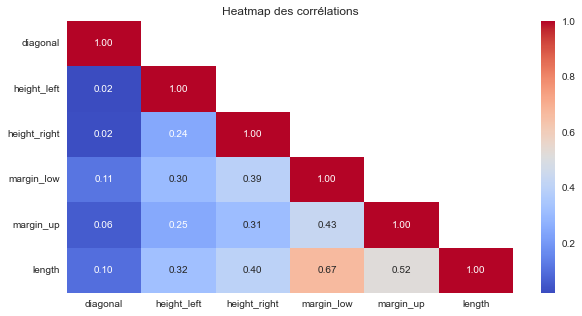

In [19]:
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(banknotes.drop(columns="is_genuine").corr().abs()),k=1)
sns.heatmap(banknotes.drop(columns="is_genuine").corr().abs(), mask=mask,cmap='coolwarm',fmt = ".2f", annot=True,annot_kws = {'size':10})
plt.title('Heatmap des corr√©lations')
plt.show()

<u>**Observation**</u><br>
*length* et *margin_low* sont les 2 variables les plus corr√©l√©es (n√©gativement -0,67) : + la longueur sera √©lev√©e, plus la marge basse sera petite, ou inversement.<br>
*length* et *margin_up* sont √©galement anticorr√©l√©s (-0.52).
____________

## Distribution 

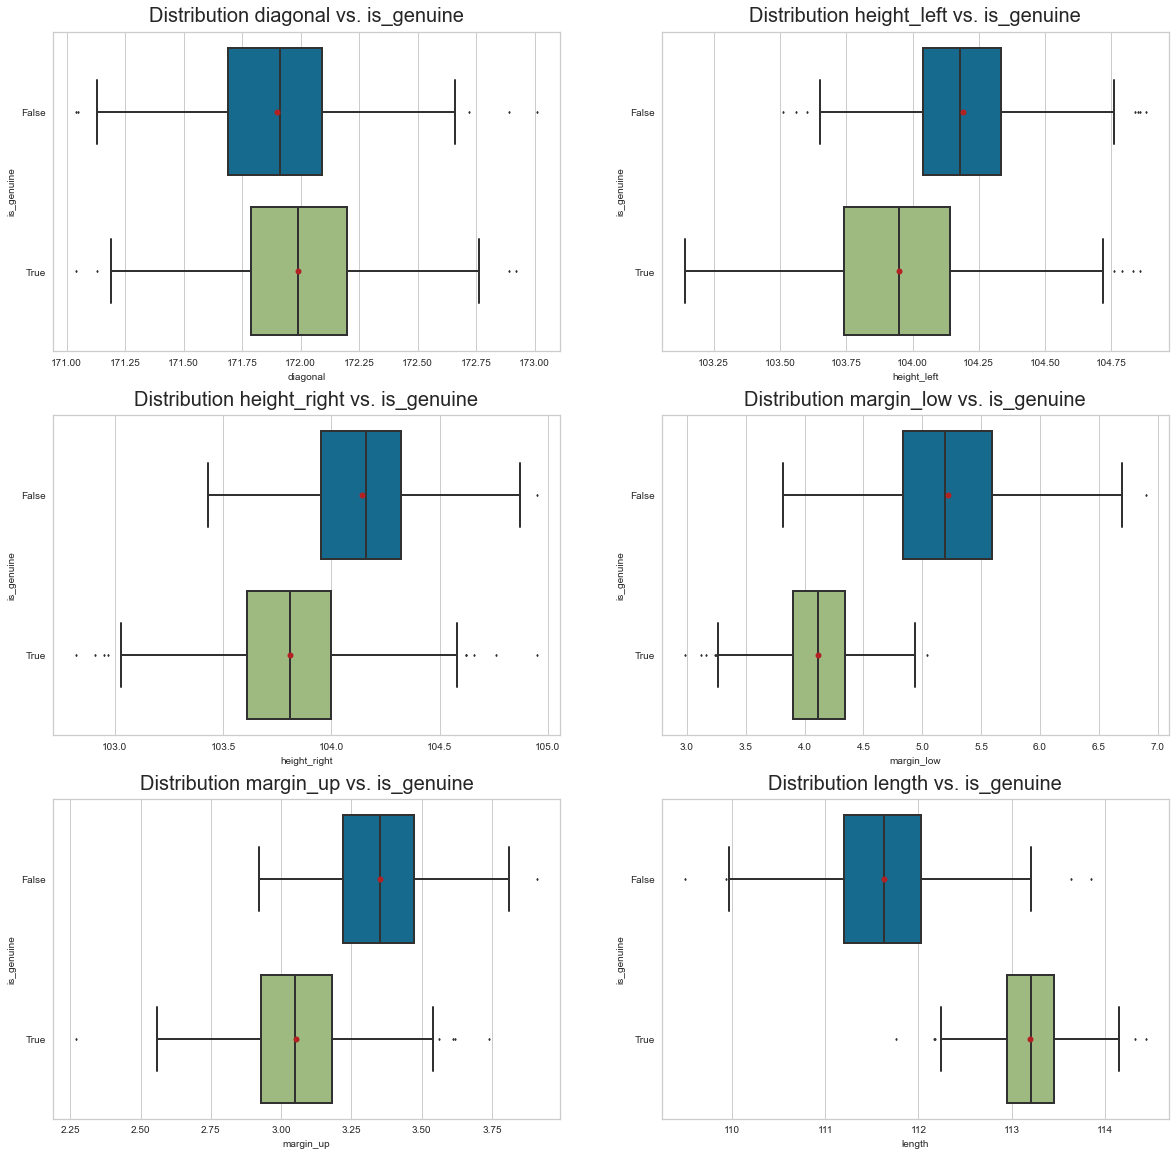

In [20]:
plot_boxes(banknotes)

<u>**Observation**</u><br>
Il y a peu d'outliers, et ils restent proches des extr√©mit√©s : on peut consid√©rer qu'ils ne sont pas g√™nants et les conserver pour l'analyse et les pr√©dictions.

Les variables *margin_low* et *lengh* permettent le mieux distinguer les vrais billets des faux, ce qui confirme l'observation faite √† partir de la matrice de corr√©lation.<br>
La *diagonale* et les hauteurs sont moins pertinentes.
_________

## Distributions bivari√©es

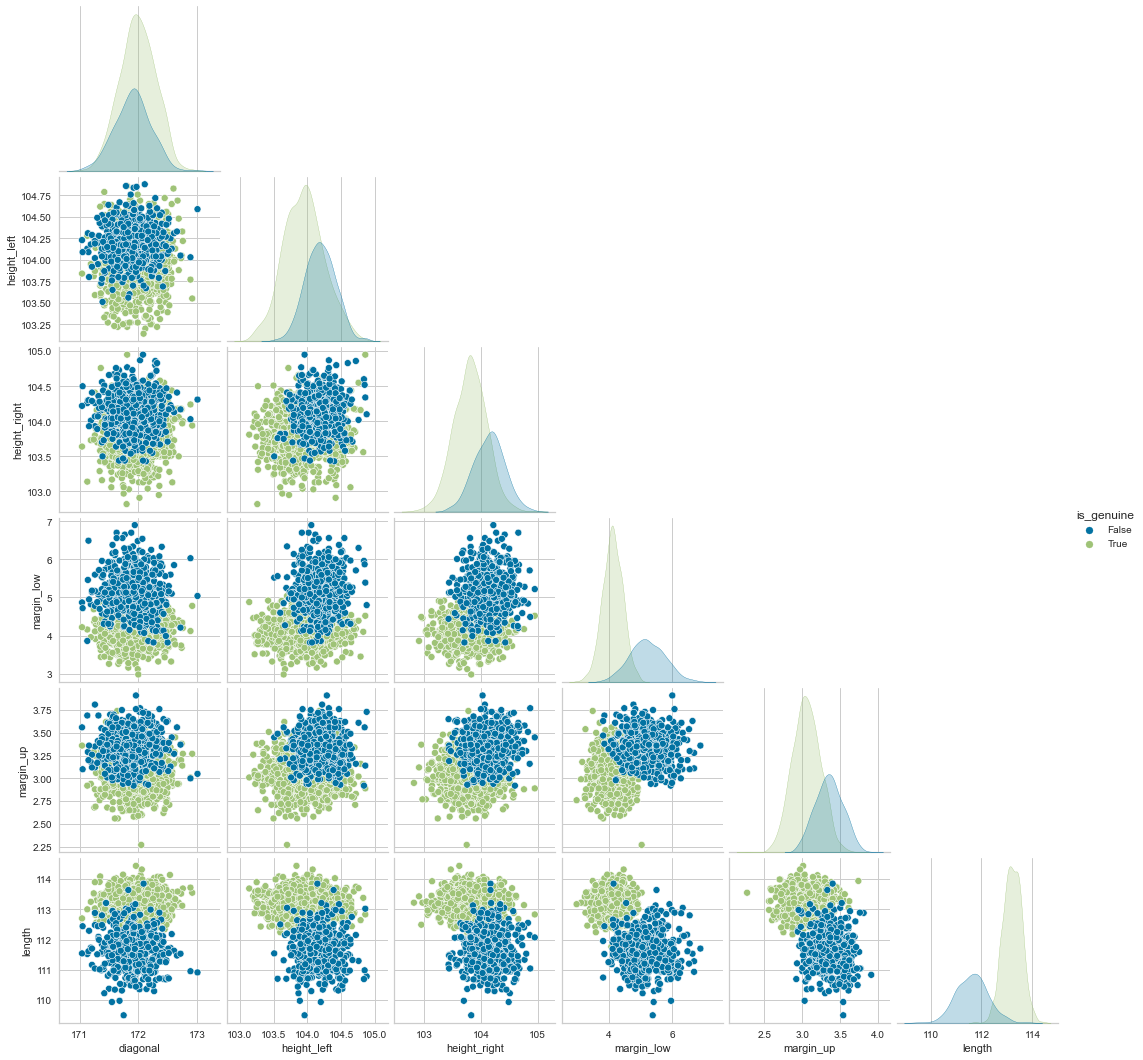

In [21]:
sns.pairplot(banknotes , hue='is_genuine', corner=True)
plt.show()

<u>**Observation**</u><br>
La visualisation confirme les observations faites sur les boites √† moustaches :<br>
- Les billets authentiques sont plus longs et ont une marge entre le bord inf√©rieur du billet et son image plus restreinte que les faux billets.<br>
- Les hauteurs sont peu discriminantes.
____________________

## R√©partition vrais/faux billets

In [22]:
distribution_is_genuine = banknotes.groupby("is_genuine").agg(number_of_banknotes=("is_genuine","count")).reset_index()
distribution_is_genuine

is_genuine  number_of_banknotes
0       False                  500
1        True                 1000

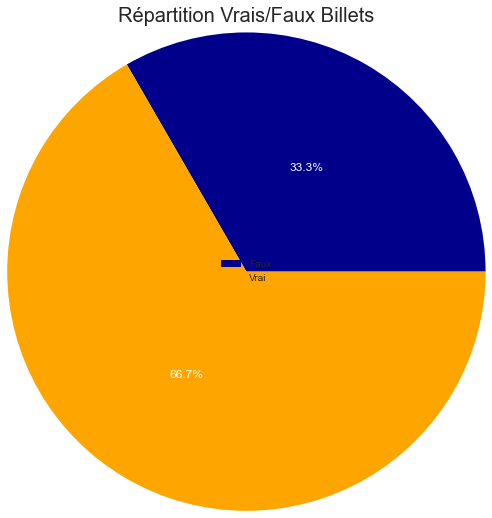

In [23]:
distribution=distribution_is_genuine.number_of_banknotes

colors = ['darkblue',"orange"]
labels=["Faux","Vrai"]

#preparing the graph
plt.pie(distribution,colors=colors, labeldistance=0.5, radius=2, pctdistance=0.5,autopct='%1.1f%%', textprops={'color':"w"})


#Legends and title
plt.title("R√©partition Vrais/Faux Billets", pad=100, loc='center', fontsize=20)
plt.legend(labels, loc="center")

plt.show()

# III. REMPLACEMENT DES VALEURS NULLES

Je r√©affiche les valeurs nulles

In [24]:
banknotes.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Je r√©organise mes colonnes pour avoir la variable √† pr√©dire en dernier

In [25]:
# shift column 'margin_low' to last position
last_column = banknotes.pop('margin_low')
  
# insert column using insert(position,column_name, column) function
banknotes.insert(banknotes.columns.size, 'margin_low', last_column)

In [26]:
banknotes

is_genuine  diagonal  height_left  height_right  margin_up  length  \
0           True    171.81       104.86        104.95       2.89  112.83   
1           True    171.46       103.36        103.66       2.99  113.09   
2           True    172.69       104.48        103.50       2.94  113.16   
3           True    171.36       103.91        103.94       3.01  113.51   
4           True    171.73       104.28        103.46       3.48  112.54   
...          ...       ...          ...           ...        ...     ...   
1495       False    171.75       104.38        104.17       3.09  111.28   
1496       False    172.19       104.63        104.44       3.37  110.97   
1497       False    171.80       104.01        104.12       3.36  111.95   
1498       False    172.06       104.28        104.06       3.46  112.25   
1499       False    171.47       104.15        103.82       3.37  112.07   

      margin_low  
0           4.52  
1           3.77  
2           4.40  
3           3.62  
4           4.04  
...          ...  
1495        4.42  
1496        5.27  
1497        5.51  
1498        5.17  
1499        4.63  

[1500 rows x 7 columns]

Je sauvegarde mes billets ayant des valeurs nulles dans un dataframe d√©di√©

In [27]:
null_notes_mask = banknotes[banknotes.margin_low.isna()]
null_notes_mask

is_genuine  diagonal  height_left  height_right  margin_up  length  \
72          True    171.94       103.89        103.45       3.25  112.79   
99          True    171.93       104.07        104.18       3.14  113.08   
151         True    172.07       103.80        104.38       3.02  112.93   
197         True    171.45       103.66        103.80       3.62  113.27   
241         True    171.83       104.14        104.06       3.02  112.36   
251         True    171.80       103.26        102.82       2.95  113.22   
284         True    171.92       103.83        103.76       3.23  113.29   
334         True    171.85       103.70        103.96       3.00  113.36   
410         True    172.56       103.72        103.51       3.12  112.95   
413         True    172.30       103.66        103.50       3.16  112.95   
445         True    172.34       104.42        103.22       3.01  112.97   
481         True    171.81       103.53        103.96       2.71  113.99   
505         True    172.01       103.97        104.05       2.98  113.65   
611         True    171.80       103.68        103.49       3.30  112.84   
654         True    171.97       103.69        103.54       2.70  112.79   
675         True    171.60       103.85        103.91       2.56  113.27   
710         True    172.03       103.97        103.86       3.07  112.65   
739         True    172.07       103.74        103.76       3.09  112.41   
742         True    172.14       104.06        103.96       3.24  113.07   
780         True    172.41       103.95        103.79       3.13  113.41   
798         True    171.96       103.84        103.62       3.01  114.44   
844         True    171.62       104.14        104.49       2.99  113.35   
845         True    172.02       104.21        104.05       2.90  113.62   
871         True    171.37       104.07        103.75       3.07  113.27   
895         True    171.81       103.68        103.80       2.98  113.82   
919         True    171.92       103.68        103.45       2.58  113.68   
945         True    172.09       103.74        103.52       3.02  112.78   
946         True    171.63       103.87        104.66       3.27  112.68   
981         True    172.02       104.23        103.72       2.99  113.37   
1076       False    171.57       104.27        104.44       3.21  111.87   
1121       False    171.40       104.38        104.19       3.17  112.39   
1176       False    171.59       104.05        103.94       3.02  111.29   
1303       False    172.17       104.49        103.76       2.93  111.21   
1315       False    172.08       104.15        104.17       3.40  112.29   
1347       False    171.72       104.46        104.12       3.61  110.31   
1435       False    172.66       104.33        104.41       3.56  111.47   
1438       False    171.90       104.28        104.29       3.24  111.49   

      margin_low  
72           NaN  
99           NaN  
151          NaN  
197          NaN  
241          NaN  
251          NaN  
284          NaN  
334          NaN  
410          NaN  
413          NaN  
445          NaN  
481          NaN  
505          NaN  
611          NaN  
654          NaN  
675          NaN  
710          NaN  
739          NaN  
742          NaN  
780          NaN  
798          NaN  
844          NaN  
845          NaN  
871          NaN  
895          NaN  
919          NaN  
945          NaN  
946          NaN  
981          NaN  
1076         NaN  
1121         NaN  
1176         NaN  
1303         NaN  
1315         NaN  
1347         NaN  
1435         NaN  
1438         NaN

In [28]:
null_notes_mask.shape

(37, 7)

## R√©gression lin√©aire multiple
Je conserve toutes mes donn√©es explicatives sauf la future valeur √† pr√©dire (is_genuine)

### Pr√©paration des donn√©es pour le mod√®le

Je supprime les valeurs NA pour pouvoir ensuite faire une r√©gression lin√©aire pour imputer les valeurs manquantes

In [29]:
banknotes_df=banknotes.copy()
banknotes_df.dropna(inplace=True)

In [30]:
X = banknotes_df[banknotes_df.columns.difference(["is_genuine","margin_low"],sort=False)]#.copy() # sort = False to keep the columns in the initial order
X

diagonal  height_left  height_right  margin_up  length
0       171.81       104.86        104.95       2.89  112.83
1       171.46       103.36        103.66       2.99  113.09
2       172.69       104.48        103.50       2.94  113.16
3       171.36       103.91        103.94       3.01  113.51
4       171.73       104.28        103.46       3.48  112.54
...        ...          ...           ...        ...     ...
1495    171.75       104.38        104.17       3.09  111.28
1496    172.19       104.63        104.44       3.37  110.97
1497    171.80       104.01        104.12       3.36  111.95
1498    172.06       104.28        104.06       3.46  112.25
1499    171.47       104.15        103.82       3.37  112.07

[1463 rows x 5 columns]

In [31]:
y = banknotes_df[["margin_low"]]
y

margin_low
0           4.52
1           3.77
2           4.40
3           3.62
4           4.04
...          ...
1495        4.42
1496        5.27
1497        5.51
1498        5.17
1499        4.63

[1463 rows x 1 columns]

Je vais encode la variable bool√©enne afin d'avoir une variable continue pour ma r√©gression avec :<br>
 - False = 0
 - True = 1
 
Il n'est pas n√©cessaire d'utiliser une m√©thode d'encoding (One hot encoding ou get_dummies) car nous avons affaire √† une variable bool√©enne qui ne prend que 2 valeurs.<br>
**Je multiplie mon dataframe par 1 pour avoir l'√©quivalent de la valeur bool√©enne en chiffre.**

In [32]:
X=X*1
X.dtypes

diagonal        float64
height_left     float64
height_right    float64
margin_up       float64
length          float64
dtype: object

In [33]:
X

diagonal  height_left  height_right  margin_up  length
0       171.81       104.86        104.95       2.89  112.83
1       171.46       103.36        103.66       2.99  113.09
2       172.69       104.48        103.50       2.94  113.16
3       171.36       103.91        103.94       3.01  113.51
4       171.73       104.28        103.46       3.48  112.54
...        ...          ...           ...        ...     ...
1495    171.75       104.38        104.17       3.09  111.28
1496    172.19       104.63        104.44       3.37  110.97
1497    171.80       104.01        104.12       3.36  111.95
1498    172.06       104.28        104.06       3.46  112.25
1499    171.47       104.15        103.82       3.37  112.07

[1463 rows x 5 columns]

On visualise la distribution de chaque variable explicative par rapport √† la variable √† pr√©dire

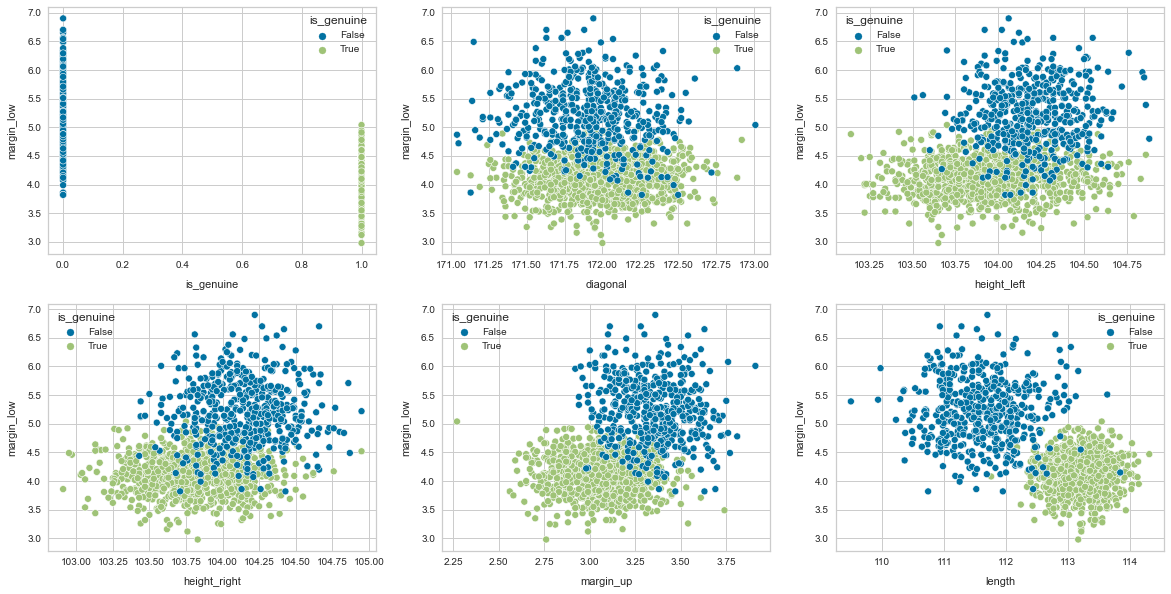

In [34]:
plot_scatter(banknotes_df)

Nos variables ont la m√™me unit√©, mais les variables li√©es √† la marge ont de bien plus petites valeurs que les dimensions du billet. Je vais donc centrer et r√©duire les donn√©es pour que les + grandes valeurs ne dominent pas compl√®tement les marges.<br>

In [35]:
#std_scale = preprocessing.StandardScaler().fit(X)

### Echantillonnage

On a 6 variables explicatives et 1 √† pr√©dire.<br>
Je s√©pare le jeu de test en cons√©quence : je cr√©e un objet X avec les variables explicatives et Y la variable √† expliquer.

In [36]:
X_marge_train, X_marge_test, y_marge_train, y_marge_test = train_test_split(X,y, test_size=0.3,random_state=42)

Je peux maintenant standardiser les donn√©es (d‚Äôentra√Ænement uniquement pour ne pas cr√©er de d√©pendance entre mon √©chantillon d'entra√Ænement et celui  de test.)

In [37]:
scaler_X_train = preprocessing.StandardScaler()
X_marge_train_std = scaler_X_train.fit_transform(X_marge_train)

### Apprentissage

In [38]:
# Construction du mod√®le
lr = LinearRegression()

# Entrainement du mod√®le
model_reg_multi = lr.fit(X_marge_train_std, y_marge_train)

### Pr√©diction

In [39]:
X_marge_test_std = scaler_X_train.transform(X_marge_test)

In [40]:
y_marge_predicted = np.round(model_reg_multi.predict(X_marge_test_std),2)

### Evaluation du mod√®le
Le score R¬≤ √©value la performance du mod√®le par rapport √† la variance des donn√©es.<br>
La **M**ean **S**quared **E**rror p√©nalise beaucoup lus les grandes erreurs que la MAE. Utile quand on accorde une grande importance aux grandes erreurs.<br> 
Avec la **M**ean **A**bsolute **E**rror, l'importance d'une erreur est lin√©aire avec son amplitude. Si les grandes erreurs sont provoqu√©es par des erreurs ab√©rrantes, alors il vaut mieux utiliser cet √©valuateur.<br>
La **M**edian **A**bsolute **E**rror est encore moins sensible aux grandes erreurs.

In [41]:
coef = pd.DataFrame(model_reg_multi.coef_.reshape(-1,1) ,index = X_marge_train.columns, columns=['Coef']) # pentes
coef.loc['Constante'] = model_reg_multi.intercept_ # ordonn√©es √† l'origine
coef

Coef
diagonal     -0.026455
height_left   0.053042
height_right  0.085015
margin_up     0.066521
length       -0.353345
Constante     4.484805

In [42]:
display_scores(y_marge_test,y_marge_predicted)

Racine carr√©e de l'erreur quadratique moyenne :  0.46505320929064264
Racine carr√©e logarithmique de l'erreur quadratique moyenne :  0.0829421107191125
Moyenne absolue des erreurs : 0.3564236902050114
M√©diane absolue des erreurs : 0.2699999999999996
Le coefficient de d√©termination (Score R¬≤ de pr√©cision) vaut: 0.49
    => Le mod√®le d√©crit 49.35% des variations de la marge inf√©rieure d'un billet.


### Visualisation des pr√©dictions
Affichage de la distribution de chaque variable explicative par rapport √† la variable pr√©dictive

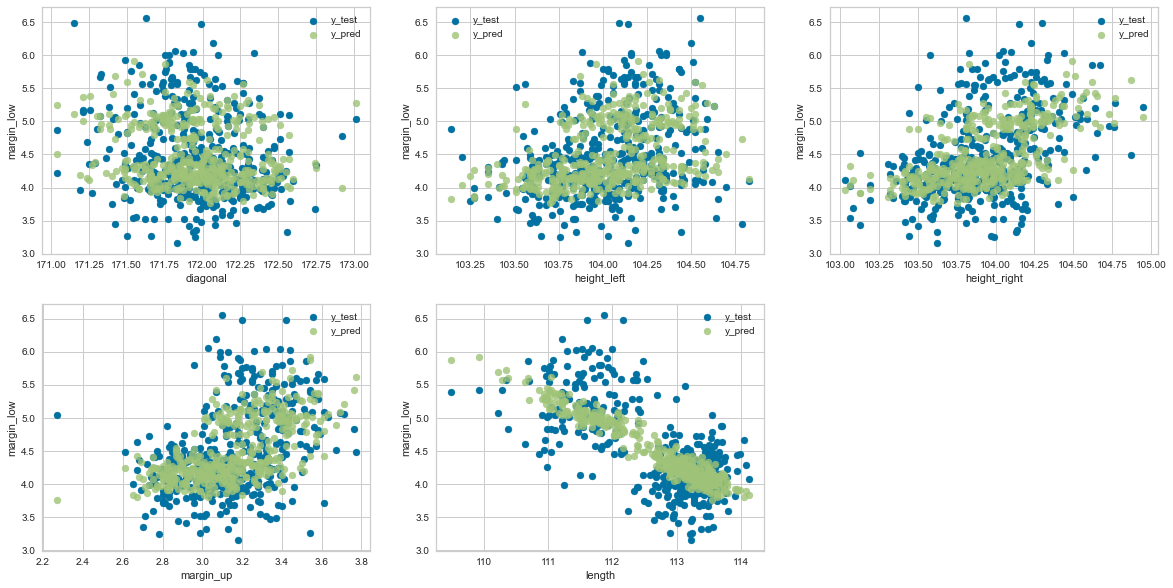

In [43]:
fig = plt.figure(figsize=(20, 10))

for i in range(X_marge_test.shape[1]):
    ax = fig.add_subplot(2,3, (i+1))
    plt.scatter(X_marge_test.iloc[:,i],y_marge_test,label="y_test")
    plt.scatter(X_marge_test.iloc[:,i],y_marge_predicted,label="y_pred", alpha=0.8)
    plt.xlabel(X_marge_test.columns[i])
    plt.ylabel("margin_low")
    plt.legend()

### Visualisation et analyse des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction d√©velopp√©e.

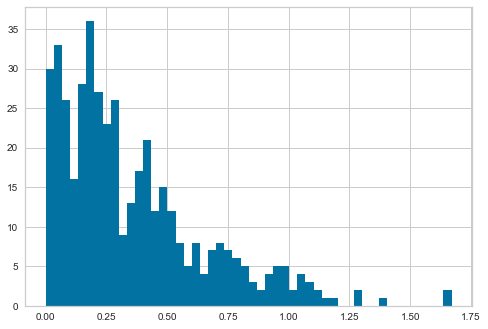

In [44]:
error_histogram(y_marge_test,y_marge_predicted)

Je calcule le nombre d'erreur < √† 10%

In [45]:
precision=pred_inf_10_percent(y_marge_test.copy(),y_marge_predicted)
print (f"{precision:.2%} des donn√©es ont une erreur de pr√©diction inf√©rieure √† 10%.")

68.79% des donn√©es ont une erreur de pr√©diction inf√©rieure √† 10%.


## R√©gression lin√©aire multiple par Statsmodels

In [46]:
reg_lin_statsmodels = sm.OLS(y_marge_train, X_marge_train).fit()
#results=reg_lin_statsmodels.fit()
print(reg_lin_statsmodels.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.749e+04
Date:                Sat, 24 Sep 2022   Prob (F-statistic):                        0.00
Time:                        18:04:05   Log-Likelihood:                         -715.52
No. Observations:                1024   AIC:                                      1441.
Df Residuals:                    1019   BIC:                                      1466.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

### Pr√©diction

In [47]:
y_marge_pred=np.round(reg_lin_statsmodels.predict(X_marge_test),2)
y_marge_pred

1208    4.97
178     4.33
281     4.38
561     4.10
891     4.00
        ... 
131     4.30
1339    5.03
339     4.24
330     4.26
666     4.01
Length: 439, dtype: float64

### Evaluation du mod√®le

In [48]:
r2=r2_score(y_marge_test,y_marge_pred)
print(f'''Le coefficient de d√©termination (Score R¬≤ de pr√©cision) vaut: {r2:.2f}
=>le mod√®le d√©crit {r2:.2%} des variations de la marge inf√©rieure d'un billet.''')

Le coefficient de d√©termination (Score R¬≤ de pr√©cision) vaut: 0.49
=>le mod√®le d√©crit 48.99% des variations de la marge inf√©rieure d'un billet.


### Visualisation et analyse des erreurs

Nous allons v√©rifier 3 hypoth√®ses sur les r√©sidus : 
- Normalit√© via le **test de Shapiro-Wilk**
- Ind√©pendance via le **test de Durbin-Watson** 
- Homog√©init√© via le **test de Breusch-Pagan**


**Normalit√© des r√©sidus**<br>

J'affiche l‚Äôhistogrammme des r√©sidus et la densit√© gaussienne pour v√©rifier la normalit√© de la distribution. <br>
La normalit√© est v√©rifi√©e √† partir de la standardisation des r√©sidus (donn√©es d√©j√† standardis√©e pour la r√©gression multiple).
Appel de la fonction d√©di√©e.

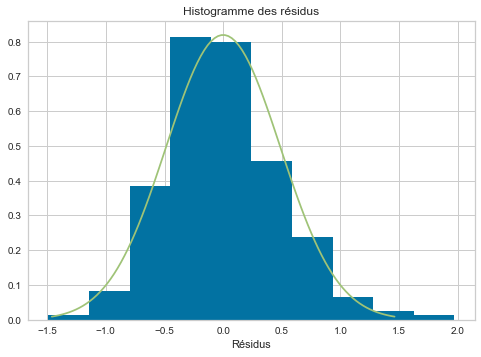

In [49]:
residual_histogram(reg_lin_statsmodels.resid)

<u>**Obervation**</u><br>
La distribution semble suivre une courbe normale qu'il faut confirmer par des chiffres.

In [50]:
shapiro_test(reg_lin_statsmodels)

Les r√©sidus ne suivent pas une loi normale, p-value valant 0.00.


**Ind√©pendance des r√©sidus**<br>

In [51]:
durbin_watson_test(reg_lin_statsmodels)

Les r√©sidus sont ind√©pendants, p-value valant 1.95.


**Homog√©init√© des r√©sidus**<br>

In [52]:
breuschpagan_test(reg_lin_statsmodels)

Les r√©sidus ne sont pas homog√®nes, p-value valant 0.00.


Je calcule le nombre d'erreur < √† 10%

In [53]:
precision=pred_inf_10_percent(y_marge_test.copy(),y_marge_pred)
print (f"Soit {precision:.2%} des donn√©es ayant une erreur de pr√©diction inf√©rieure √† 10%.")

Soit 68.56% des donn√©es ayant une erreur de pr√©diction inf√©rieure √† 10%.


## R√©gression lin√©aire simple 

Puisque *margin_low* est anticorr√©l√©e √† *length*, je vais me servir de cette corr√©lation pour pr√©dire la valeur recherch√©e. 

### S√©paration du jeu de donn√©es

In [54]:
X2=banknotes_df[["length"]]
X2

length
0     112.83
1     113.09
2     113.16
3     113.51
4     112.54
...      ...
1495  111.28
1496  110.97
1497  111.95
1498  112.25
1499  112.07

[1463 rows x 1 columns]

In [55]:
y2=banknotes_df[["margin_low"]]
y2

margin_low
0           4.52
1           3.77
2           4.40
3           3.62
4           4.04
...          ...
1495        4.42
1496        5.27
1497        5.51
1498        5.17
1499        4.63

[1463 rows x 1 columns]

### Echantillonnage

In [56]:
X_marge_train2, X_marge_test2, y_marge_train2, y_marge_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

### Apprentissage

In [57]:
# Construction du mod√®le
lr2 = LinearRegression()

# Entrainement du mod√®le
model_reg_simple = lr2.fit(X_marge_train2, y_marge_train2)

### Pr√©diction

In [58]:
y_marge_predicted2 = model_reg_simple.predict(X_marge_test2)

### Evaluation du mod√®le

In [59]:
display_scores(y_marge_test2, y_marge_predicted2)

Racine carr√©e de l'erreur quadratique moyenne :  0.4782246714259774
Racine carr√©e logarithmique de l'erreur quadratique moyenne :  0.08546279037284812
Moyenne absolue des erreurs : 0.3664766213916956
M√©diane absolue des erreurs : 0.2824909784214116
Le coefficient de d√©termination (Score R¬≤ de pr√©cision) vaut: 0.46
    => Le mod√®le d√©crit 46.44% des variations de la marge inf√©rieure d'un billet.


### Visualisation des pr√©dictions

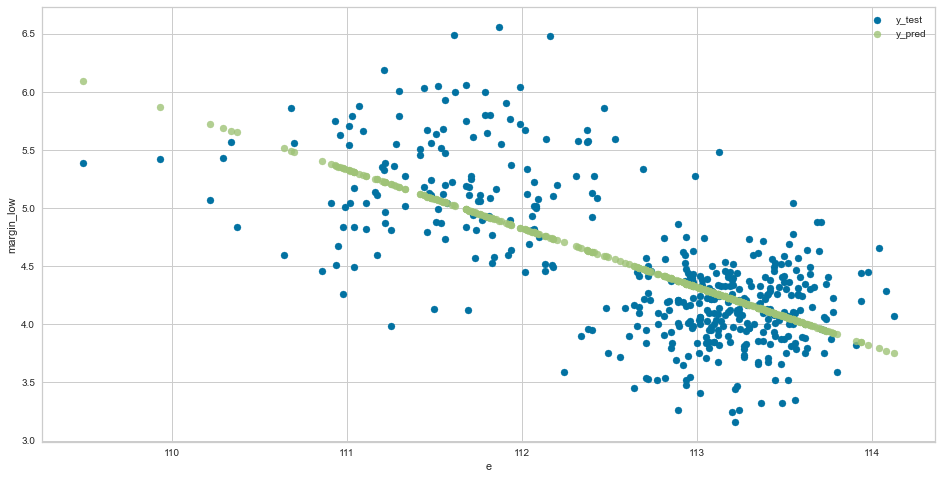

L'√©quation du mod√®le vaut : Y = -0.51 X +  61.46


In [60]:
fig = plt.figure(figsize=(16, 8))

plt.scatter(X_marge_test2,y_marge_test2,label="y_test")
plt.scatter(X_marge_test2,y_marge_predicted2,label="y_pred", alpha=0.8)
plt.xlabel("e")
plt.ylabel("margin_low")
plt.legend()
plt.show()


a = round(float(model_reg_simple.coef_),2)
b = round(float(model_reg_simple.intercept_),2)
print("L'√©quation du mod√®le vaut : Y =",a,"X + ",b)


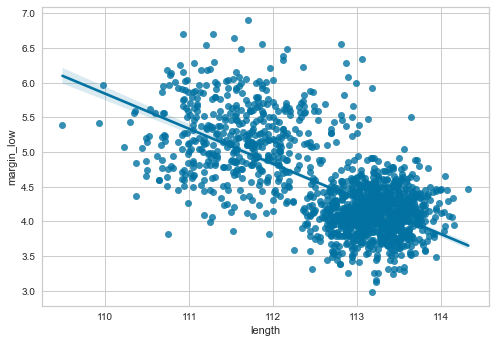

In [61]:
sns.regplot(x="length",y="margin_low",data=banknotes_df)
plt.show()

### Visualisation et analyses des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction d√©velopp√©e.

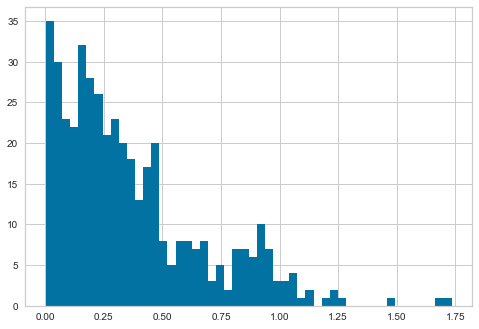

In [62]:
error_histogram(y_marge_test2,y_marge_predicted2)

Je calcule le nombre d'erreur < √† 10%

In [63]:
precision=pred_inf_10_percent(y_marge_test2.copy(),y_marge_predicted2)
print (f"Soit {precision:.2%} des donn√©es ayant une erreur de pr√©diction inf√©rieure √† 10%.")

Soit 70.39% des donn√©es ayant une erreur de pr√©diction inf√©rieure √† 10%.


## R√©gression lin√©aire simple par statsmodels

In [64]:
reg_simple_statsmodels = sm.OLS(y_marge_train2, X_marge_train2).fit()

print(reg_simple_statsmodels.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          4.299e+04
Date:                Sat, 24 Sep 2022   Prob (F-statistic):                        0.00
Time:                        18:04:06   Log-Likelihood:                         -1075.0
No. Observations:                1024   AIC:                                      2152.
Df Residuals:                    1023   BIC:                                      2157.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Pr√©diction

In [65]:
y_pred2=np.round(reg_simple_statsmodels.predict(X_marge_test2),2)

### Evaluation du mod√®le

In [66]:
r2=r2_score(y_marge_test2,y_pred2)
print(f"""Le coefficient de d√©termination (Score R¬≤ de pr√©cision) vaut: {r2:.2f}
=> Le mod√®le d√©crit {r2:.2%} des variations de la marge inf√©rieure d'un billet.""")

Le coefficient de d√©termination (Score R¬≤ de pr√©cision) vaut: -0.07
=> Le mod√®le d√©crit -7.47% des variations de la marge inf√©rieure d'un billet.


### Visualisation et analyse des erreurs

**Normalit√© des r√©sidus**

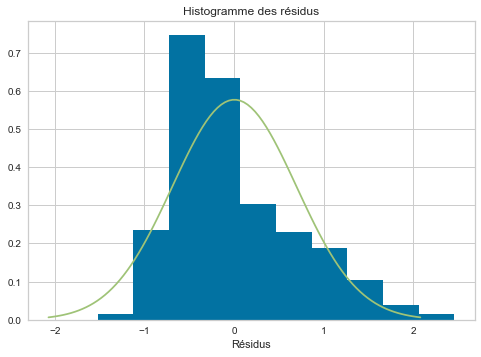

In [67]:
residual_histogram(reg_simple_statsmodels.resid)

<u>**Obervation**</u><br>
La distribution ne semble pas suivre une courbe normale. Je le confirme avec le test de Shapiro-Wilk qui teste la normalit√© des r√©sidus o√π :

In [68]:
shapiro_test(reg_simple_statsmodels)

Les r√©sidus ne suivent pas une loi normale, p-value valant 0.00.


**Ind√©pendance des r√©sidus**

In [69]:
durbin_watson_test(reg_simple_statsmodels)

Les r√©sidus sont ind√©pendants, p-value valant 1.97.


**Homog√©init√© des r√©sidus**

In [70]:
breuschpagan_test(reg_simple_statsmodels)

Les r√©sidus ne sont pas homog√®nes, p-value valant 0.00.


Je calcule le nombre d'erreur < √† 10%

In [71]:
precision=pred_inf_10_percent(y_marge_test2.copy(),y_pred2)
print (f"Soit {precision:.2%} des donn√©es ayant une erreur de pr√©diction inf√©rieure √† 10%.")

Soit 45.33% des donn√©es ayant une erreur de pr√©diction inf√©rieure √† 10%.


## KNNImputer (avec GridSearchCV)

In [72]:
X_knni = banknotes_df.copy()
X_knni = X_knni.drop(columns=["is_genuine","margin_low"])
X_knni

diagonal  height_left  height_right  margin_up  length
0       171.81       104.86        104.95       2.89  112.83
1       171.46       103.36        103.66       2.99  113.09
2       172.69       104.48        103.50       2.94  113.16
3       171.36       103.91        103.94       3.01  113.51
4       171.73       104.28        103.46       3.48  112.54
...        ...          ...           ...        ...     ...
1495    171.75       104.38        104.17       3.09  111.28
1496    172.19       104.63        104.44       3.37  110.97
1497    171.80       104.01        104.12       3.36  111.95
1498    172.06       104.28        104.06       3.46  112.25
1499    171.47       104.15        103.82       3.37  112.07

[1463 rows x 5 columns]

In [73]:
y_knni=banknotes_df.copy()
y_knni=y_knni[["margin_low"]]
y_knni

margin_low
0           4.52
1           3.77
2           4.40
3           3.62
4           4.04
...          ...
1495        4.42
1496        5.27
1497        5.51
1498        5.17
1499        4.63

[1463 rows x 1 columns]

### Echantillonnage


In [74]:
X_knni_train, X_knni_test, y_knni_train, y_knni_test = train_test_split(X_knni,y_knni,train_size=0.7, random_state=42)

Je standardise mes donn√©es d'entra√Ænement et j'applique ensuite la transformation sur mes donn√©es d'entra√Ænement et de test

In [75]:
scaler_X_knni_train = preprocessing.StandardScaler()
X_knni_train_std=scaler_X_knni_train.fit_transform(X_knni_train)
X_knni_test_std = scaler_X_knni_train.transform(X_knni_test)

Je cr√©√© une pipeline qui va contenir mon knnimputer et un algorithme de r√©gression.<br>


In [76]:
model = make_pipeline(KNNImputer(), LinearRegression())

Je vais utiliser le transformeur avec GridSearchCV afin d'optimiser les caract√©ristiques de mon KNNImputer. <br>
Je cr√©√© un dictionnaire de param√®tres de ce que je souhaite optimiser, principalement le nombre de voisins optimal.

In [77]:
params = {
    'knnimputer__n_neighbors' : np.arange(1,31),
    'knnimputer__weights': ['uniform', 'distance']
}

In [78]:
grid = GridSearchCV(model,param_grid=params,cv=10)

J'entra√Æne ma grid sur mes donn√©es

In [79]:
grid.fit(X_knni_train_std, y_knni_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('knnimputer', KNNImputer()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'knnimputer__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'knnimputer__weights': ['uniform', 'distance']})

Affichage des meilleurs param√®tres.

In [80]:
print("Les meilleurs param√®tres sont : ",grid.best_params_)

Les meilleurs param√®tres sont :  {'knnimputer__n_neighbors': 1, 'knnimputer__weights': 'uniform'}


In [81]:
y_marge_knni_predicted = np.round(grid.predict(X_knni_test_std),2)

### Evaluation du mod√®le
Le score R¬≤ √©value la performance du mod√®le par rapport √† la variance des donn√©es.<br>
La **M**ean **S**quared **E**rror p√©nalise beaucoup lus les grandes erreurs que la MAE. Utile quand on accorde une grande importance aux grandes erreurs.<br> 
Avec la **M**ean **A**bsolute **E**rror, l'importance d'une erreur est lin√©aire avec son amplitude. Si les grandes erreurs sont provoqu√©es par des erreurs ab√©rrantes, alors il vaut mieux utiliser cet √©valuateur.<br>
La **M**edian **A**bsolute **E**rror est encore moins sensible aux grandes erreurs.

In [82]:
display_scores(y_knni_test, y_marge_knni_predicted)

Racine carr√©e de l'erreur quadratique moyenne :  0.46505320929064264
Racine carr√©e logarithmique de l'erreur quadratique moyenne :  0.0829421107191125
Moyenne absolue des erreurs : 0.3564236902050114
M√©diane absolue des erreurs : 0.2699999999999996
Le coefficient de d√©termination (Score R¬≤ de pr√©cision) vaut: 0.49
    => Le mod√®le d√©crit 49.35% des variations de la marge inf√©rieure d'un billet.


### Visualisation des pr√©dictions
Affichage de la distribution de chaque variable explicative par rapport √† la variable pr√©dictive

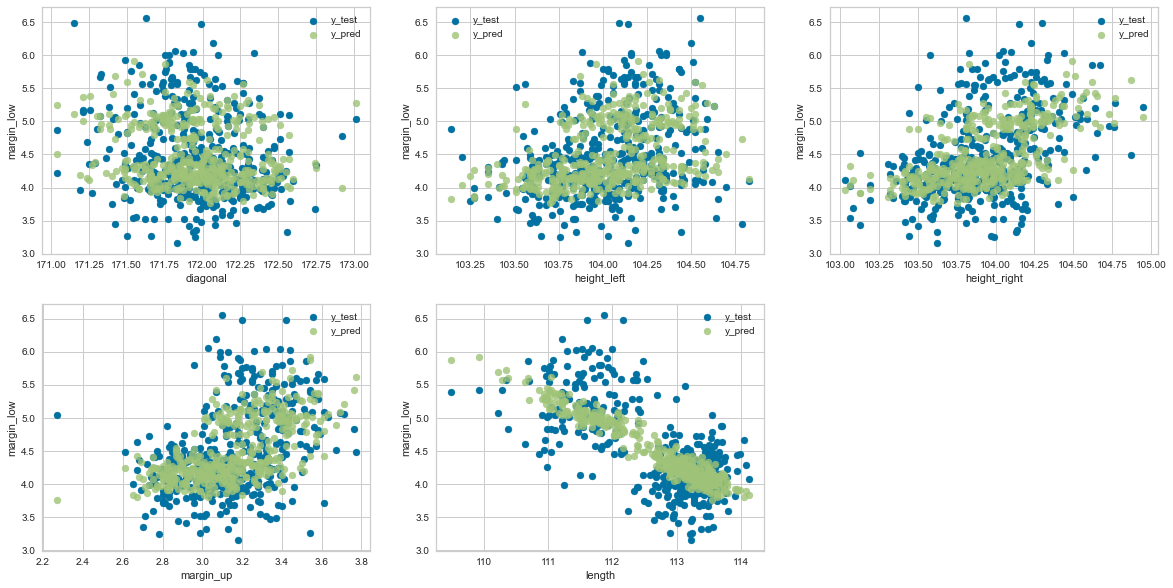

In [83]:
fig = plt.figure(figsize=(20, 10))

for i in range(X_marge_test.shape[1]):
    ax = fig.add_subplot(2,3, (i+1))
    plt.scatter(X_marge_test.iloc[:,i],y_knni_test,label="y_test")
    plt.scatter(X_marge_test.iloc[:,i],y_marge_knni_predicted,label="y_pred", alpha=0.8)
    plt.xlabel(X_marge_test.columns[i])
    plt.ylabel("margin_low")
    plt.legend()

### Visualisation des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction d√©velopp√©e.

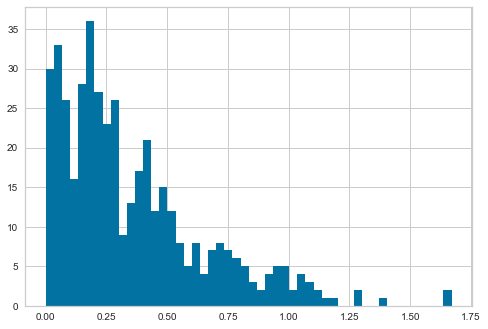

In [84]:
error_histogram(y_knni_test,y_marge_knni_predicted)

Je calcule le nombre d'erreur < √† 10%

In [85]:
precision=pred_inf_10_percent(y_knni_test.copy(), y_marge_knni_predicted)
print (f"{precision:.2%} des donn√©es ont une erreur de pr√©diction inf√©rieure √† 10%.")

68.79% des donn√©es ont une erreur de pr√©diction inf√©rieure √† 10%.


## KNNImputer

La m√©thode KNNImputer ne s'applique que sur des donn√©es num√©riques.<br>
Je vais dupliquer mon dataframe sans les NaN puis utiliser la totalit√© de ce dataframe dans lequel je vais injecter 2.5% de nan.<br>
Je vais ensuite v√©rifier le r√©sultat par rapport au dataframe d'origine et regarder les √©carts.

In [86]:
banknotes_df_KNNI = banknotes_df.copy()
banknotes_df_KNNI=banknotes_df_KNNI.drop(columns="is_genuine")
banknotes_df_KNNI.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_up', 'length',
       'margin_low'],
      dtype='object')

J'injecte 2.5% de NaN dans la colonne margin_low, soit 37 valeurs vides au hasard.


In [87]:
banknotes_df_knn_with_Nan=banknotes_df_KNNI.copy()
banknotes_df_knn_with_Nan['margin_low'] = banknotes_df_KNNI['margin_low'].sample(frac=0.975, random_state=42)
banknotes_df_knn_with_Nan.isna().sum()

diagonal         0
height_left      0
height_right     0
margin_up        0
length           0
margin_low      37
dtype: int64

Je sauvegarde les valeurs nulles dans un dataframe ainsi que les indexes.

In [88]:
NaN_banknotes_df_knn=banknotes_df_knn_with_Nan[banknotes_df_knn_with_Nan.margin_low.isna()]
NaN_banknotes_df_knn.head(5)

diagonal  height_left  height_right  margin_up  length  margin_low
21     171.82       103.65        103.64       2.80  112.57         NaN
88     171.93       103.65        103.56       2.77  112.95         NaN
123    171.62       104.24        103.85       2.90  112.87         NaN
132    171.84       103.77        103.98       2.99  113.59         NaN
258    171.71       103.53        103.78       3.03  113.51         NaN

In [89]:
index_NaN=NaN_banknotes_df_knn.index
index_NaN

Int64Index([  21,   88,  123,  132,  258,  282,  338,  351,  393,  470,  477,
             486,  523,  716,  766,  789,  826,  880,  884,  896,  984, 1004,
            1073, 1112, 1126, 1154, 1157, 1161, 1216, 1247, 1270, 1328, 1367,
            1372, 1431, 1474, 1496],
           dtype='int64')

### D√©termination du meilleur k

Je cr√©√© mon dataframe ne contenant que mes valeurs avant remplacement par des Nan

In [90]:
true_values=pd.DataFrame(banknotes_df_KNNI.margin_low.loc[index_NaN])

Je teste mon imputation pour plusieurs valeurs de k

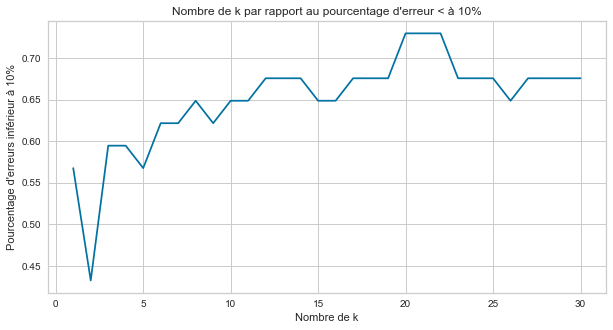

In [91]:
result=pd.DataFrame(columns=["k","Pourcentage erreur <10%"])
for i in range (1,31) :
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=i, weights="distance")
    imputer.fit(banknotes_df_knn_with_Nan)
    banknotes_df_knn_pred = pd.DataFrame(imputer.transform(banknotes_df_knn_with_Nan), columns = banknotes_df_knn_with_Nan.columns, index=banknotes_df_knn_with_Nan.index)
    banknotes_df_knn_pred = banknotes_df_knn_pred.round(2)
    
    # Je stocke la valeur pr√©dite
    pred_values = banknotes_df_knn_pred.margin_low.loc[index_NaN]

    #J'√©value mon mod√®le
    precision=pred_inf_10_percent(true_values.copy(),pred_values)

    # Je stocke mes r√©sultats d'√©valuation
    result = pd.concat([result,pd.DataFrame.from_records([
                       {'k': i,"Pourcentage erreur <10%":precision}])], ignore_index=True)
    # result = result.append({'k': i,"Pourcentage erreur <10%":precision}, ignore_index=True)
plt.figure(figsize=(10,5))
plt.plot(result.k,result["Pourcentage erreur <10%"])
plt.xlabel("Nombre de k")
plt.ylabel("Pourcentage d'erreurs inf√©rieur √† 10%")
plt.title("Nombre de k par rapport au pourcentage d'erreur < √† 10%")
plt.show()

In [92]:
optimal_k = max(result["Pourcentage erreur <10%"])
optimal_k = result["k"][result["Pourcentage erreur <10%"]==optimal_k]
if optimal_k.shape[0]>1:
    optimal_k=min(optimal_k)
    print(f"La valeur de K la plus optimis√©e est {int(optimal_k)}.")
else:
    print(f"La valeur de K la plus optimis√©e est {int(optimal_k)}.")

La valeur de K la plus optimis√©e est 20.


### Imputation

J'impute avec le k optimal

In [93]:
imputer = KNNImputer(n_neighbors=optimal_k, weights="distance")
imputer.fit(banknotes_df_knn_with_Nan)
banknotes_df_knn_pred = pd.DataFrame(imputer.transform(banknotes_df_knn_with_Nan), columns = banknotes_df_knn_with_Nan.columns, index=banknotes_df_knn_with_Nan.index)
banknotes_df_knn_pred=banknotes_df_knn_pred.round(2)
banknotes_df_knn_pred.isna().sum()

diagonal        0
height_left     0
height_right    0
margin_up       0
length          0
margin_low      0
dtype: int64

### Evaluation du mod√®le

In [94]:
precision=pred_inf_10_percent(true_values,banknotes_df_knn_pred.margin_low)
print (f"{precision:.2%} des donn√©es ont une erreur de pr√©diction inf√©rieure √† 10%.")

72.97% des donn√©es ont une erreur de pr√©diction inf√©rieure √† 10%.


### Visualisation des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction d√©velopp√©e.<br>
Je transforme mon pred_values en array pour le passer en param√®tre de error_histogram, et je ne conserve que margin_low de mon df.

In [95]:
pred_values=np.array(pred_values).reshape(-1,1)

In [96]:
true_values=pd.DataFrame(true_values.margin_low)

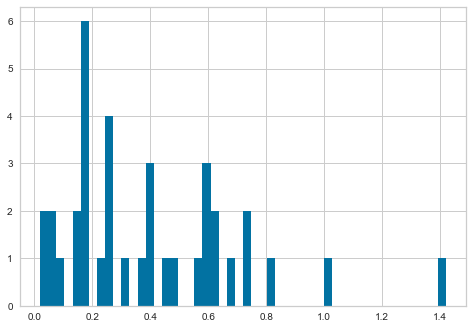

In [97]:
error_histogram(true_values,pred_values)

### Visualisation des pr√©dictions

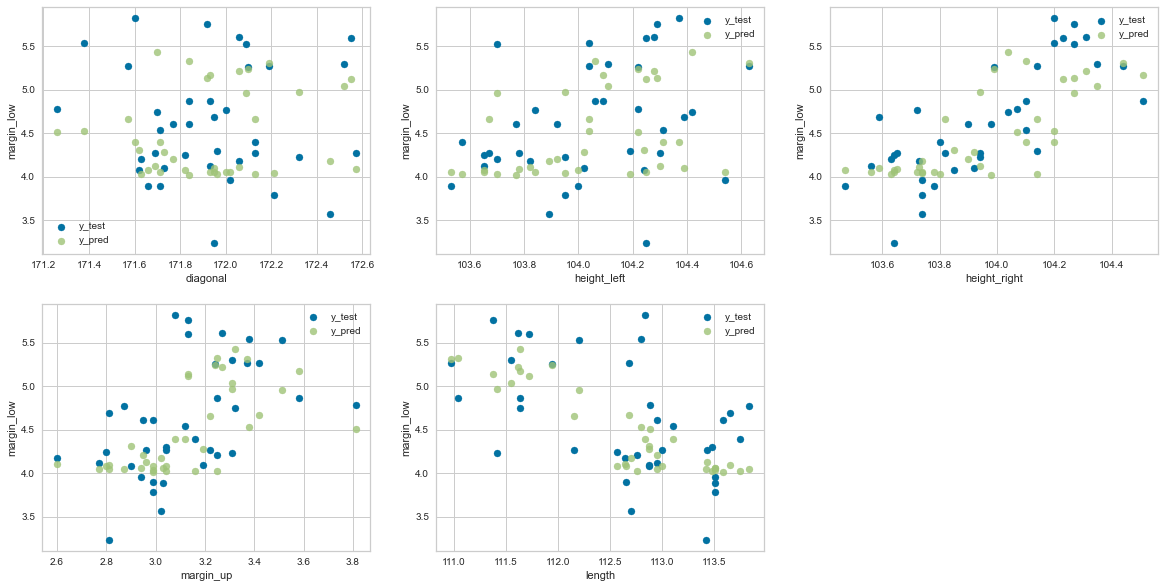

In [98]:
fig = plt.figure(figsize=(20, 10))

for i in range(banknotes_df_KNNI.shape[1]):

    if banknotes_df_KNNI.columns[i]!="margin_low":
        ax = fig.add_subplot(2,3, (i+1))
        plt.scatter(banknotes_df_KNNI.loc[index_NaN,banknotes_df_KNNI.columns[i]],true_values,label="y_test")
        plt.scatter(banknotes_df_KNNI.loc[index_NaN,banknotes_df_KNNI.columns[i]],pred_values,label="y_pred", alpha=0.8)
        plt.xlabel(banknotes_df_KNNI.columns[i])
        plt.ylabel("margin_low")
        plt.legend()

## KNN Regressor

On utilise la m√©thode des proches voisins mais cette fois avec une m√©thode qui va pr√©dire les valeurs manquantes.

KNeighborsRegressor est utilis√© pour pr√©dire les variables de r√©ponse, tandis que KNNImputer est utilis√© pour remplacer les valeurs manquantes sur les variables de caract√©ristiques.

### S√©paration du jeu de donn√©es

In [99]:
data = banknotes_df[banknotes_df.columns.difference(["is_genuine","margin_low"],sort=False)].copy() # sort = False to keep the columns in the initial order
data

diagonal  height_left  height_right  margin_up  length
0       171.81       104.86        104.95       2.89  112.83
1       171.46       103.36        103.66       2.99  113.09
2       172.69       104.48        103.50       2.94  113.16
3       171.36       103.91        103.94       3.01  113.51
4       171.73       104.28        103.46       3.48  112.54
...        ...          ...           ...        ...     ...
1495    171.75       104.38        104.17       3.09  111.28
1496    172.19       104.63        104.44       3.37  110.97
1497    171.80       104.01        104.12       3.36  111.95
1498    172.06       104.28        104.06       3.46  112.25
1499    171.47       104.15        103.82       3.37  112.07

[1463 rows x 5 columns]

In [100]:
target = banknotes_df[["margin_low"]]
target

margin_low
0           4.52
1           3.77
2           4.40
3           3.62
4           4.04
...          ...
1495        4.42
1496        5.27
1497        5.51
1498        5.17
1499        4.63

[1463 rows x 1 columns]

### Echantillonnage

In [101]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(data,target,train_size=0.7)

Standardisation sur les donn√©es d'entra√Ænement

In [102]:
#scaler_X_train_knn = preprocessing.StandardScaler()
#X_train_knn_std=scaler_X_train_knn.fit_transform(X_train_knn)

J'applique la standardisation sur mib jeu de test 

In [103]:
#X_train_knn_std = std_scale.transform(X_train_knn)
#X_test_knn_std = scaler_X_train_knn.transform(X_test_knn)

Je reforme mes dataframe "cass√©s" apr√®s la standardisation

In [104]:
#X_train_knn=pd.DataFrame(X_train_knn,columns=X_train_knn.columns,index=X_train_knn.index)
#X_train_knn

### Apprentissage

Construction du mod√®le. Je d√©marre par le k optimal de ma pr√©c√©dente imputation.

In [105]:
print (f"Apprentissage avec {optimal_k} voisins.")
model_knn_imputer = KNeighborsRegressor(n_neighbors=optimal_k) #https://stackoverflow.com/questions/45645716/unknown-label-type-continuous

Apprentissage avec 20 voisins.


Entra√Ænement du mod√®le

In [106]:
model_knn_imputer.fit(X_train_knn, y_train_knn)

KNeighborsRegressor(n_neighbors=20)

### Evaluation du mod√®le

In [107]:
print(f"Le score vaut {model_knn_imputer.score(X_test_knn,y_test_knn):.2%}")

Le score vaut 49.31%


In [108]:
print (f"Le pourcentage d'erreur est {1-model_knn_imputer.score(X_test_knn,y_test_knn):.2%}")

Le pourcentage d'erreur est 50.69%


**1re m√©thode pour trouver le k optimal**

Pour am√©liorer mon mod√®le, je vais utiliser une boucle pour d√©tecter le meilleur k avec :
- La m√©thode de cross-validation
- Sans la m√©thode cross validation



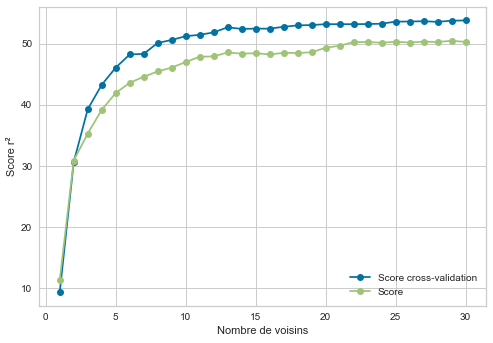

In [109]:
scores_cv=[]
scores = []
for k in range (1,31):
    model_knn_imputer = KNeighborsRegressor(n_neighbors=k)
    score_cv=cross_val_score(model_knn_imputer,X_train_knn,y_train_knn, cv=10,scoring="r2",)
    scores_cv.append(100*score_cv.mean())
    score=model_knn_imputer.fit(X_train_knn, y_train_knn).score(X_test_knn,y_test_knn)
    scores.append(100*score.mean())
plt.plot(range(1,31),scores_cv,'-o',label="Score cross-validation")
plt.plot(range(1,31),scores,'-o',label="Score")
plt.xlabel("Nombre de voisins")
plt.ylabel("Score r¬≤")
plt.legend()
plt.show()

Les courbes sont proches. On va se baser sur le meilleur score de cross-validation

In [110]:
best_score=0# j'initialise haut la plus basse valeur d'erreur
for index,score_cv in enumerate(scores_cv):
    if best_score < score_cv: 
        best_score=score_cv
        optimal_k=index+1 # +2 pour correspondre √† la liste des k

print (f"Notre classifieur optimal est {optimal_k}")

Notre classifieur optimal est 30


**2e m√©thode pour trouver le k optimal**

In [111]:
# Fixer les valeurs des hyperparam√®tres √† tester
param_grid = {'n_neighbors':np.arange(1,31)}#, 'weights':["uniform","distance"]}

# Choisir un score √† optimiser, ici r2
score = 'r2'

# Cr√©er un classifieur kNN avec recherche d'hyperparam√®tre par validation crois√©e
clf_knn_reg = GridSearchCV(neighbors.KNeighborsRegressor(), # un classifieur kNN
    param_grid,     # hyperparam√®tres √† tester
    cv=10,          # nombre de folds de validation crois√©e
    scoring=score,   # score √† optimiser
)

# Optimiser ce classifieur sur le jeu d'entra√Ænement
clf_knn_reg.fit(X_train_knn, y_train_knn)

# Afficher le(s) hyperparam√®tre(s) optimaux
print("Meilleur(s) hyperparam√®tre(s) sur le jeu d'entra√Ænement:",clf_knn_reg.best_params_)


Meilleur(s) hyperparam√®tre(s) sur le jeu d'entra√Ænement: {'n_neighbors': 30}


In [112]:
# Afficher les performances correspondantes
print("R√©sultats de la validation crois√©e :")
for mean, std, params in zip(
        clf_knn_reg.cv_results_['mean_test_score'], # score moyen
        clf_knn_reg.cv_results_['std_test_score'],  # √©cart-type du score
        clf_knn_reg.cv_results_['params']           # valeur de l'hyperparam√®tre
    ):
    print(f"{score} = {mean:.3f} (+/-{std*2:.03f}) for {params}")

R√©sultats de la validation crois√©e :
r2 = 0.093 (+/-0.207) for {'n_neighbors': 1}
r2 = 0.306 (+/-0.170) for {'n_neighbors': 2}
r2 = 0.392 (+/-0.178) for {'n_neighbors': 3}
r2 = 0.432 (+/-0.161) for {'n_neighbors': 4}
r2 = 0.461 (+/-0.158) for {'n_neighbors': 5}
r2 = 0.482 (+/-0.155) for {'n_neighbors': 6}
r2 = 0.483 (+/-0.163) for {'n_neighbors': 7}
r2 = 0.501 (+/-0.138) for {'n_neighbors': 8}
r2 = 0.506 (+/-0.142) for {'n_neighbors': 9}
r2 = 0.512 (+/-0.141) for {'n_neighbors': 10}
r2 = 0.514 (+/-0.142) for {'n_neighbors': 11}
r2 = 0.518 (+/-0.147) for {'n_neighbors': 12}
r2 = 0.527 (+/-0.143) for {'n_neighbors': 13}
r2 = 0.524 (+/-0.147) for {'n_neighbors': 14}
r2 = 0.524 (+/-0.140) for {'n_neighbors': 15}
r2 = 0.524 (+/-0.139) for {'n_neighbors': 16}
r2 = 0.527 (+/-0.136) for {'n_neighbors': 17}
r2 = 0.530 (+/-0.135) for {'n_neighbors': 18}
r2 = 0.530 (+/-0.133) for {'n_neighbors': 19}
r2 = 0.532 (+/-0.135) for {'n_neighbors': 20}
r2 = 0.532 (+/-0.135) for {'n_neighbors': 21}
r2 =

Je choisis l'un des 2 mod√®les entre model_knn_imputer et clf qui retournent le m√™me r√©sultat.<br>
Si je choisissais model_knn_imputer, il faudrait que je passe le k optimal <br>
- model_knn_imputer = KNeighborsRegressor(n_neighbors=optimal_k) puis que je le r√©entraine<br>
- model_knn_imputer.fit(X_train_knn, y_train_knn) et enfin que je pr√©dise<br>
- y_predicted_knn=np.round(model_knn_imputer.predict(X_test_knn),2)

In [113]:
y_predicted_knn = clf_knn_reg.predict(X_test_knn)

In [114]:
print(f"Le score r2 vaut {clf_knn_reg.score(X_test_knn,y_test_knn):.2%}")

Le score r2 vaut 50.27%


In [115]:
print (f"Le pourcentage d'erreur est {1-model_knn_imputer.score(X_test_knn,y_test_knn):.2%}")

Le pourcentage d'erreur est 49.73%


### Visualisation des pr√©dictions
Affichage de la distribution de chaque variable explicative par rapport √† la variable pr√©dictive

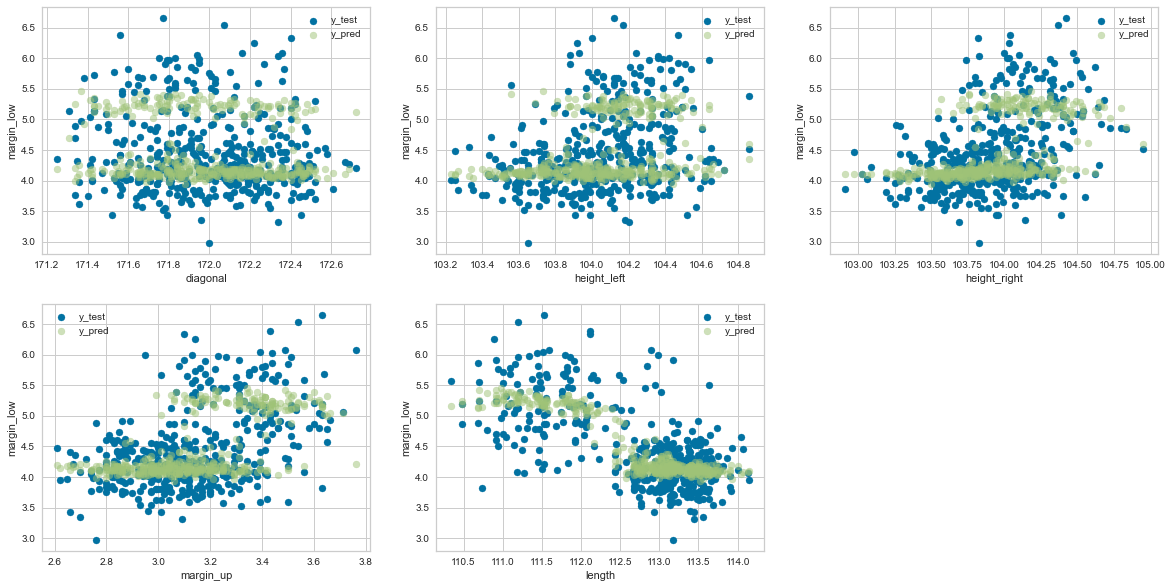

In [116]:
fig = plt.figure(figsize=(20, 10))

for i in range(X_test_knn.shape[1]):
    ax = fig.add_subplot(2,3, (i+1))
    plt.scatter(X_test_knn.iloc[:,i],y_test_knn,label="y_test")
    plt.scatter(X_test_knn.iloc[:,i],y_predicted_knn,label="y_pred", alpha=0.5)
    plt.xlabel(X_test_knn.columns[i])
    plt.ylabel("margin_low")
    plt.legend()

In [117]:
display_scores(y_test_knn, y_predicted_knn)

Racine carr√©e de l'erreur quadratique moyenne :  0.45900796570331315
Racine carr√©e logarithmique de l'erreur quadratique moyenne :  0.08080839844720178
Moyenne absolue des erreurs : 0.33849886104783594
M√©diane absolue des erreurs : 0.2600000000000007
Le coefficient de d√©termination (Score R¬≤ de pr√©cision) vaut: 0.50
    => Le mod√®le d√©crit 50.27% des variations de la marge inf√©rieure d'un billet.


### Visualisation des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction d√©velopp√©e.

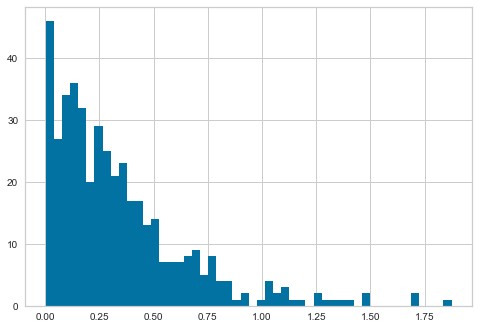

In [118]:
error_histogram(y_test_knn,y_predicted_knn)

Je mets les informations dans un dataframe

In [119]:
precision=pred_inf_10_percent(y_test_knn,y_predicted_knn)
print (f"{precision:.2%} des donn√©es ont une erreur de pr√©diction inf√©rieure √† 10%.")

73.58% des donn√©es ont une erreur de pr√©diction inf√©rieure √† 10%.


## Conclusion

**La m√©thode obtenant la meilleure √©valuation est celle du KNN Regressor : meilleur score r2 et meilleur score en terme de pourcentage d'erreurs inf√©rieures √† 10%.<br>**

La m√©thode de r√©gression lin√©aire multiple donne le meilleur scrore r2 des r√©gressions lin√©aires. Mais les conditions d'application ne sont pas toutes respect√©es (normalit√© et homosc√©dastict√© des r√©sidus).<br>
Nous allons donc proc√©der √† l'imputation finale des valeurs manquantes via les valeurs obtenues par la r√©gression des KNN.

Je r√©cup√®re le dataframe null_notes_mask contenant uniquement les valeurs nulles sur lesquelles nous allons proc√©der √† l'imputation

In [120]:
null_notes_mask.head()

is_genuine  diagonal  height_left  height_right  margin_up  length  \
72         True    171.94       103.89        103.45       3.25  112.79   
99         True    171.93       104.07        104.18       3.14  113.08   
151        True    172.07       103.80        104.38       3.02  112.93   
197        True    171.45       103.66        103.80       3.62  113.27   
241        True    171.83       104.14        104.06       3.02  112.36   

     margin_low  
72          NaN  
99          NaN  
151         NaN  
197         NaN  
241         NaN

Je supprime les colonnes *is_genuine* et *margin_low* pour avoir le m√™me dataframe en entr√©e que lorsque j'ai entra√Æn√© mon mod√®le.

In [121]:
values_to_predict=null_notes_mask.drop(columns=["is_genuine","margin_low"])
values_to_predict.head()

diagonal  height_left  height_right  margin_up  length
72     171.94       103.89        103.45       3.25  112.79
99     171.93       104.07        104.18       3.14  113.08
151    172.07       103.80        104.38       3.02  112.93
197    171.45       103.66        103.80       3.62  113.27
241    171.83       104.14        104.06       3.02  112.36

Je centre et r√©duis mes donn√©es et les remets au format dataframe (pour r√©gression lin√©aire multiple) 

In [122]:
#values_to_predict_std=std_scale.transform(values_to_predict)
#values_to_predict_std=pd.DataFrame(values_to_predict_std, columns=values_to_predict.columns)
#values_to_predict_std.head()

In [123]:
predict_margin_low = np.round(clf_knn_reg.predict(values_to_predict),2) #.values si warning et mod√®le de r√©gression lin√©aire

Je mets mes donn√©es au format Series (uniquement des chiffres √† la place d'un array) pour pouvoir les affecter √† la colonne margin_low de mon dataframe

In [124]:
predict_margin_low=pd.Series(predict_margin_low[:,0],index=values_to_predict.index)
predict_margin_low

72      4.08
99      4.20
151     4.18
197     4.17
241     4.55
251     4.09
284     4.22
334     4.11
410     4.02
413     4.10
445     4.10
481     4.18
505     4.09
611     4.03
654     4.05
675     4.11
710     4.26
739     4.29
742     4.19
780     4.10
798     4.14
844     4.17
845     4.11
871     4.16
895     4.15
919     4.27
945     4.08
946     4.76
981     3.99
1076    5.24
1121    4.91
1176    5.33
1303    5.29
1315    5.03
1347    5.19
1435    5.16
1438    5.26
dtype: float64

J'affiche le nombre de valeurs nulles avant imputation

In [125]:
banknotes.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_up        0
length           0
margin_low      37
dtype: int64

J'applique ma pr√©diction sur les valeurs manquantes de *margin_low* de mon df pr√©par√©.

In [126]:
banknotes.loc[null_notes_mask.index, "margin_low"]= predict_margin_low

V√©rification de l'imputation sur nos 37 valeurs

In [127]:
banknotes.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_up       0
length          0
margin_low      0
dtype: int64

In [128]:
banknotes.iloc[[72,1438],6]

72      4.08
1438    5.26
Name: margin_low, dtype: float64

# IV. MODELES D'IDENTIFICATION VRAIS/FAUX BILLETS

Cette fois, la variable √† expliquer est *is_genuine* en fonction des 6 autres variables explicatives qui sont toutes num√©riques.

Je r√©organiser mon dataframe pour avoir les colonnes dans l'ordre initial

In [129]:
banknotes=banknotes.reindex(columns=['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'])

## R√©gression logistique

Une r√©gression logistique est plus pertinente avec des variables explicatives binaires : comme il s'agit de faire une classification (Vrai ou Faux), nous allons utiliser ce type de r√©gression.

### S√©paration du jeu de donn√©es

In [130]:
X = banknotes[banknotes.columns.difference(["is_genuine"], sort=False)]
X

diagonal  height_left  height_right  margin_low  margin_up  length
0       171.81       104.86        104.95        4.52       2.89  112.83
1       171.46       103.36        103.66        3.77       2.99  113.09
2       172.69       104.48        103.50        4.40       2.94  113.16
3       171.36       103.91        103.94        3.62       3.01  113.51
4       171.73       104.28        103.46        4.04       3.48  112.54
...        ...          ...           ...         ...        ...     ...
1495    171.75       104.38        104.17        4.42       3.09  111.28
1496    172.19       104.63        104.44        5.27       3.37  110.97
1497    171.80       104.01        104.12        5.51       3.36  111.95
1498    172.06       104.28        104.06        5.17       3.46  112.25
1499    171.47       104.15        103.82        4.63       3.37  112.07

[1500 rows x 6 columns]

Je multiplie mon dataframe par 1 pour avoir l'√©quivalent de la valeur bool√©enne en chiffre.

In [131]:
y = banknotes["is_genuine"]
y = y*1

### Echantillonnage
L'√©chantillonnage est al√©atoire mais je "stratifiet" la classe "is_genuine" pour avoir une r√©partition proportionnelle de vrais et faux billets sur le jeu de donn√©es "train" et "test".

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)
print (f"""Le jeu de donn√©es d'entra√Ænement contient {X_train.shape[0]} lignes.
Le jeu de test en contient {X_test.shape[0]}.""")

Le jeu de donn√©es d'entra√Ænement contient 1050 lignes.
Le jeu de test en contient 450.


### Apprentissage

In [192]:
lr = LogisticRegression(max_iter=2000) #je fixe un max_iter sup√©rieur √† la valeur par d√©faut (1000) pour √©viter le warning dans ma courbe ROC

model_reg_log = lr.fit(X_train, y_train)
model_reg_log

LogisticRegression(max_iter=2000)

### Evaluation du mod√®le

Scores

In [193]:
print(f"Train Score : {lr.score(X_train,y_train):.2%}")
print(f"Test Score : {lr.score(X_test,y_test):.2%}")

Train Score : 99.05%
Test Score : 98.89%


Je regarde le coefficient de chaque variable. ‚ö†Ô∏è Mais si je veux les comparer, je dois centrer r√©duire les donn√©es.

In [194]:
coef = pd.DataFrame(model_reg_log.coef_[0,] ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = model_reg_log.intercept_
coef

Coef
diagonal     -0.239408
height_left  -1.411236
height_right -2.135576
margin_low   -3.357415
margin_up    -2.710823
length        3.861396
Constante    -0.023821

In [195]:
y_pred = model_reg_log.predict(X_test)

#### Pr√©cision (Precision)

C‚Äôest-√†-dire la proportion de pr√©dictions correctes parmi les points que l‚Äôon a pr√©dits positifs. C‚Äôest la capacit√© de notre mod√®le √† identifier un vrai billet qui est r√©ellement authentique.<br>
*Pr√©cision= TP / (TP+FP)*

In [196]:
precision = round(metrics.precision_score(y_test, y_pred)*100,2)
print(f"Prz√©cision du mod√®le de r√©gression logistique : {precision}%")

Prz√©cision du mod√®le de r√©gression logistique : 99.0%


#### Rappel (Recall)

Egalement appel√© sensibilit√© ("sensitivity" en anglais), correspond au taux de vrais positifs, c‚Äôest √† dire la proportion de positifs que l‚Äôon a correctement identifi√©s parmi toutes les donn√©es r√©ellement positives. C‚Äôest la capacit√© de notre mod√®le √† d√©tecter tous les vrais billets.<br>
*Rappel = TP / (TP+FN)*

In [197]:
recall=round(metrics.recall_score(y_test, y_pred)*100,2)
print(f"Rappel du mod√®le de r√©gression logistique : {recall}%")

Rappel du mod√®le de r√©gression logistique : 99.33%


#### Justesse (Accuracy)
Correspond √† la proportion de points correctement pr√©dits.<br>
*Accuracy = (TP + TN) / Total*

In [198]:
accuracy=round(metrics.accuracy_score(y_test, y_pred)*100,2)
print(f"Justesse du mod√®le de r√©gression logistique : {accuracy}%")

Justesse du mod√®le de r√©gression logistique : 98.89%


#### Sp√©cificit√© (sp√©cificit√©)
C'est le taux de vrais n√©gatifs, l'inverse du recall<br>
*Specificity =TN / (FP+TN)*

In [199]:
specificity=round(metrics.recall_score(y_test, y_pred,pos_label=0)*100,2) # le param√®tre pos_label = 0 permet d'obtenir l'√©quivalent du recall de la calsse n√©gative
print(f"Sp√©cificit√© du mod√®le de r√©gression logistique : {specificity}%")

Sp√©cificit√© du mod√®le de r√©gression logistique : 98.0%


#### F-mesure
Pour √©valuer un compromis entre rappel et pr√©cision, on calcule la "F-mesure" ou "F-score", qui est leur moyenne harmonique.

Affichage du F1_score : le F1-score √©value la capacit√© d‚Äôun mod√®le de classification √† pr√©dire efficacement les individus positifs, en faisant un compromis entre la precision et le recall. 

In [200]:
f_mesure = round(metrics.f1_score(y_test,y_pred)*100,2)
print(f"La f-mesure vaut {f_mesure}%")

La f-mesure vaut 99.17%


In [201]:
log_reg_model_evaluation = pd.DataFrame(data=[precision,recall,accuracy,specificity,f_mesure], index=["precision","recall","accuracy","specificity","f_mesure"], columns=["measures_log_reg"])
log_reg_model_evaluation

measures_log_reg
precision               99.00
recall                  99.33
accuracy                98.89
specificity             98.00
f_mesure                99.17

#### Synth√®se des mesures

In [202]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       150
           1       0.99      0.99      0.99       300

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



#### Matrice de confusion

Affiche la r√©partition entre :
- True Positives
- False Positives
- True Negatives
- False Negatives

In [203]:
pd.crosstab(y_test, y_pred, colnames=['Pr√©dictions'], rownames=['Observations'], margins=True)

Pr√©dictions     0    1  All
Observations               
0             147    3  150
1               2  298  300
All           149  301  450

In [204]:
matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
print(matrix)

[[147   3]
 [  2 298]]


Repr√©sentation graphique de la matrice de confusion

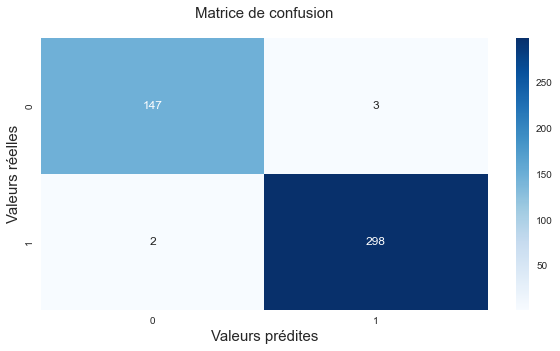

In [205]:
plot_crosstab(matrix, "Matrice de confusion")

 ‚ö†Ô∏è Attention la matrice de confusion d√©pend du seuil de classification. Le seuil implicite vaut 50%.

#### Probabilit√© et seuil de classification
Dans un r√©gression logistique, predict_proba() renvoie une probabilit√© des classes auxquelles appartient l'instance.<br>
Un tableau 2 dimensions est retourn√© avec le pourcentage de probabilit√© d'√™tre classifi√© 0 pour la 1re colonne, et 1 pour la seconde.

In [206]:
probas_pred=model_reg_log.predict_proba(X_test)
pd.DataFrame(probas_pred, index=X_test.index)

0         1
913   0.041758  0.958242
655   0.012208  0.987792
475   0.001481  0.998519
663   0.000147  0.999853
1254  0.999960  0.000040
...        ...       ...
1267  0.910328  0.089672
517   0.006270  0.993730
252   0.005158  0.994842
474   0.023081  0.976919
1496  0.999965  0.000035

[450 rows x 2 columns]

Je cr√©√© un dataframe pour y stocker, pour chaque seuil test√©, le score associ√©, ce qui va me permettre d'identifier le score le plus efficace pour ce jeu de test.<br>


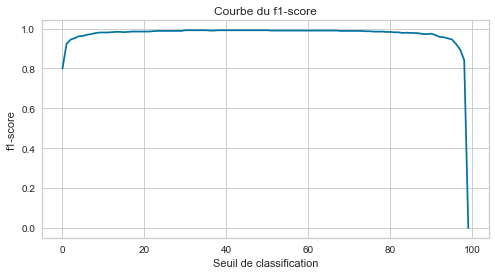

f1-score seuil
0        0.8     0
1   0.924499     1
2   0.944882     2
3   0.952381     3
4   0.961538     4
..       ...   ...
95  0.945518    96
96  0.922801    97
97  0.895028    98
98  0.841699    99
99       0.0   100

[100 rows x 2 columns]

In [207]:
threshold_array = np.linspace(0, 1, 100) # On va tester chaque pourcentage de 1 √† 100
f1_results=pd.DataFrame(columns=["f1-score","seuil"])

# Labels pr√©dits pour un seuil donn√© allant de 0 √† 100%
for threshold in threshold_array:
    label_pred_threshold = (probas_pred[:,1] > threshold).astype(int) # astype(int) permet de basculer le r√©sultat en 1 / 0 plut√¥t que True/False
    # Calcul de la matrice de confusion pour un seuil donn√©
    matrix_threshold = metrics.confusion_matrix(y_true=y_test, y_pred=label_pred_threshold)
    scores = metrics.f1_score(y_test,label_pred_threshold)
    # store results
    f1_results=pd.concat([f1_results,pd.DataFrame.from_records([{"f1-score":scores,"seuil":int(round(threshold*100,0))}])],ignore_index=True)

plt.figure(figsize=(8,4))
plt.plot(f1_results["f1-score"])
plt.xlabel("Seuil de classification")
plt.ylabel("f1-score")
plt.title("Courbe du f1-score")
plt.show()
f1_results

J'identifie les seuils ayant obtenus le meilleur scrore f1.

In [208]:
best_class_threshold=max(f1_results["f1-score"])
best_threshold=f1_results.seuil[f1_results["f1-score"]==best_class_threshold]

print (f'''Le(s) meilleur(s) seuil(s) est(sont) : {best_threshold.values}''')

Le(s) meilleur(s) seuil(s) est(sont) : [30 31 32 33 34 35]


Je relance ma matrice de confusion en fixant le seuil.

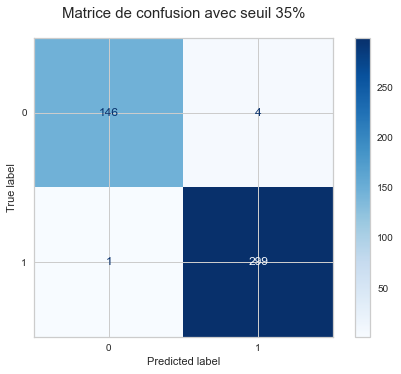

In [209]:
# D√©finition d'un seuil de classification 
threshold = max(best_threshold)/100

# Labels pr√©dits pour un seuil donn√©
label_pred_threshold = (probas_pred[:,1] > threshold).astype(int)

# Affichage de la matrice de confusion pour un seuil donn√©
ConfusionMatrixDisplay.from_predictions(y_test,label_pred_threshold,cmap="Blues")
plt.title (f"Matrice de confusion avec seuil {threshold:.0%}", pad=20, fontsize=15)
plt.show()

üö® Pour ce jeu de test, nous avons d√©fini le meilleur seuil de classification.<br>
Mais pour √™tre vraiment pertinent, il ne faut pas se baser uniquement sur les donn√©es de test retenues mais par validation crois√©e sur les donn√©es d'apprentissage. <br>
En effectuant un ajustement du seuil sur les donn√©es de test, on pourrait aboutir √† un surapprentissage et on sera trop d√©pendant de ces donn√©es, cr√©ant une variance.<br>


#### Courbe de ROC
La courbe ROC (Receiver Operating Characteristic) repr√©sente la sensibilit√© en fonction de la sp√©cificit√© pour diff√©rents seuils de d√©cision. <br>
L'aire sous la courbe ROC, l'AUC (Area Under the (ROC) Curve ), est une mesure de la qualit√© de la classification qui varie entre 0.5 dans pour une classification al√©atoire et 1 dans le meilleur des cas.

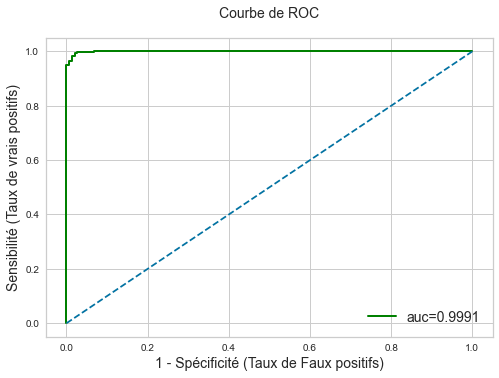

Notre aire sous la courbe (AUC) vaut 0.9991333333333333.


In [210]:
#R√©cup√©ration de la pr√©diction de la valeur positive
#y_pred_proba = lr.predict_proba(X_test)[:,1] 

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probas_pred[:,1])
auc = metrics.auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, linestyle="-", label=f"auc={np.round(auc,4)}")
plt.plot([0, 1], [0, 1], linestyle='--') # Trac√© de la droite classifieur al√©atoire
plt.xlabel('1 - Sp√©cificit√© (Taux de Faux positifs)', fontsize=14)
plt.ylabel('Sensibilit√© (Taux de vrais positifs)', fontsize=14)
plt.title('Courbe de ROC',fontsize=14, pad=20)
plt.legend(fontsize=14)
plt.show()
print(f"Notre aire sous la courbe (AUC) vaut {auc}.")
#print(pd.DataFrame(thresholds))

#### Courbe Precision/Recall

Pr√©diction des valeurs et des probabilit√©s de test_y en fonction du mod√®le de r√©gression logistique ajust√© (fit)

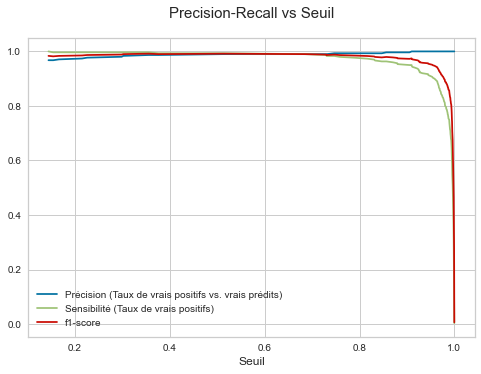

0.9995656973624212.


In [211]:
# Retrieve probability of being 1 (in second column of probas_pred)
precision, recall, threshold = precision_recall_curve(y_test, probas_pred[:,1]) 

# Putting results in a dataframe (minus last line for precision and recall to have the same number of lines than threshold)
df = pd.DataFrame(dict(precision=precision[:-1], recall=recall[:-1],threshold=threshold))

# Adding the f1 score (kind of mean between precision and recall)
df['f1-score']=2 * (df.precision * df.recall) / (df.precision + df.recall)

pr_auc = metrics.auc(recall, precision)

df.plot(x="threshold", y=["precision","recall","f1-score"], label=["Pr√©cision (Taux de vrais positifs vs. vrais pr√©dits)","Sensibilit√© (Taux de vrais positifs)",'f1-score'])


#ax=df.plot(x="threshold", y=["precision","recall"], label=["Pr√©cision (Taux de vrais positifs vs. vrais pr√©dits)","r"])
#ax = dfpr.plot(x="threshold", y=['precision', 'recall', 'F1'], figsize=(4, 4))

plt.title("Precision-Recall vs Seuil", pad=20,fontsize=15)
plt.xlabel("Seuil", fontsize=12)
plt.legend(loc="lower left")
#plt.xlim([0,1])
plt.show()
print(f"{pr_auc}.")


In [212]:
higher_score=max(df["f1-score"])
df[df["f1-score"]==higher_score]

precision    recall  threshold  f1-score
7   0.986799  0.996667   0.355303  0.991708

<u>**Observation**</u><br>
On n'a pas besoin d'optimiser selon un seuil, entre 0.40 et 0.8 c'est tr√®s bien. Par d√©faut, le seuil vaut 0.5.

#### Courbe d'apprentissage

Nombre de donn√©es d'entra√Ænement : [189 378 567 756 945]


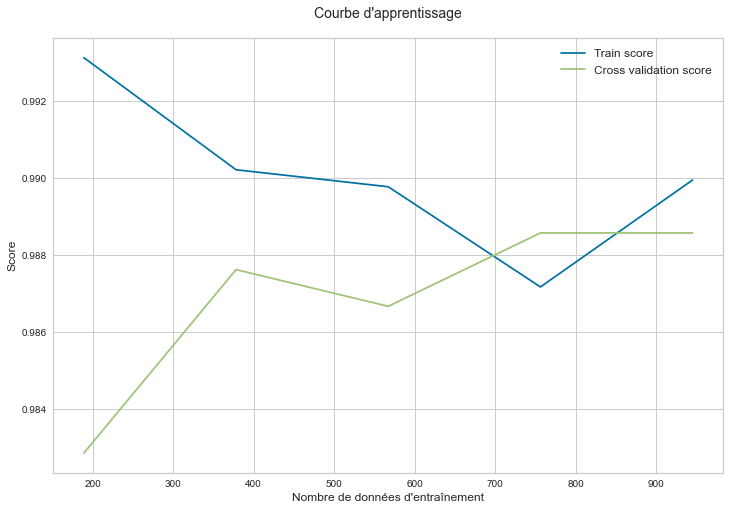

In [213]:
N, train_score, val_score,  = learning_curve(lr, X_train, y_train, cv=10, train_sizes=np.linspace(0.2, 1, 5)) # 5 lots de 20 √† 100%

print ("Nombre de donn√©es d'entra√Ænement :" ,N)

plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='Train score')
plt.plot(N, val_score.mean(axis=1), label='Cross validation score')
plt.title("Courbe d'apprentissage",pad=20, size=14) 
plt.xlabel("Nombre de donn√©es d'entra√Ænement",fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(fontsize=12)
plt.show()

<u>**Observation**</u><br>
La courbe d'apprentissage a d√©j√† de tr√®s bon scores, l'axe y est tr√®s ress√©r√©. Plus de donn√©es n'aideraient pas √† am√©liorer le mod√®le.

## Clustering
Je vais commencer par regrouper mes variables via une ACP

### Analyse en Composantes Principales (PCA)

Pour rappel, la valeur propre associ√©e √† un axe correspond √† la fraction d‚Äôinertie qu‚Äôil retranscrit. Plus elle  est  √©lev√©e,  plus  le  facteur  est  important  dans  la  lecture  des  r√©sultats. L‚Äôenjeu  justement  est  de 
d√©celer √† partir de quel stade l‚Äôinformation restitu√©e peut √™tre consid√©r√©e n√©gligeable. En tenant compte de plusieurs  √©l√©ments  
- le  nombre d‚Äôobservations ¬´n¬ª
- le  nombre de  variables  ¬´p¬ª de l‚Äôanalyse
- le  ratio  ¬´n:p¬ª entre  le  nombre d‚Äôobservations et le nombre de variables
- le  degr√©  de  liaison  (la  corr√©lation)  entre  les  variables
- l‚Äôexistence √©ventuelle de blocs de variables corr√©l√©es dans le tableau de donn√©es.

Le ratio  ¬´n:p¬ª  est  particuli√®rement  important,  il  d√©termine  la  stabilit√©  des  r√©sultats.  Certaines r√©f√©rences affirment qu‚Äôune ACP n‚Äôest vraiment viable que s‚Äôil est sup√©rieur √† 3.

‚û°Ô∏è Nous avons 1500/6 = 250 dans notre fichier. Nous pouvons travailler en confiance sur l'ACP.

L'ACP permet donc de trouver les directions selon lesquelles la Variance de donn√©es est maximale pour perdre le moins d'informations possible quand on les projette.

On va afficher la table des valeurs propres de nos donn√©es (indiquant pour chacun des composantes, la valeur propre, le pourcentage de variance expliqu√© par la composante (taux d'inertie) et le pourcentage cumul√© de variance expliqu√©e pour nous aider √† choisit le nombre de composantes.

<u>Quelques m√©thodes pour choisir le nombre de composantes principales √† conserver</u> :

1. **La qualit√© de repr√©sentation du nuage de points** Comme le nombre de CP est √©gal au nombre de variables d'origine, il ne faut retenir que les CP qui expliquent le plus la variance (70-95%) pour faciliter l'interpr√©tation. Plus les CP conserv√©es expliquent la majorit√© des variations dans les donn√©es d'origine, meilleur sera le mod√®le PCA. Ceci est hautement subjectif et bas√© sur l'interpr√©tation de l'utilisateur.=> <u>M√©thode √† ne pas utiliser seule.</u>

2. **Le crit√®re de Kayser** : Dans une ACP norm√©e, la somme des valeurs propres √©tant √©gale  au  nombre  de  variables,leur moyenne vaut 1.  Nous  consid√©rons par  cons√©quent qu‚Äôun axe est int√©ressant si sa valeur propre est sup√©rieure √† 1. G√©n√©ralement, les CP avec des valeurs propres> 1 contribuent √† une plus grande variance et doivent √™tre conserv√©s pour une analyse plus approfondie.<br>
On peut aussi le calculer ainsi : on a tendance √† ne pas consid√©rer comme importants les axes dont l‚Äôinertie associ√©e est inf√©rieure √† (100/p)% , car ils repr√©sentent moins de variabilit√© qu‚Äôune seule variable initiale. La valeur de (100/p)% est celle obtenue quand toutes les variables sont ind√©pendantes deux √† deux. => <u>M√©thode √† ne pas utiliser, en tout cas pas seule.</u>

3. **La r√®gle de R√®gle de Karlis ‚Äì Saporta - Spinaki.** On pense  g√©n√©ralement que le seuil de 1 est trop permissif. Une r√®gle plus restrictive consiste √† le d√©finir comme suit: <br>
‚û°Ô∏è moyenne des valeurs propres  +  2  fois  leur  √©cart-type. 

Nous serons d‚Äôautant plus exigeants (enclins √† accepter moins de facteurs) que le nombre de variables ¬´p¬ª est √©lev√© par rapport aux observations disponibles ¬´n¬ª.<br>
Formule : 1+2(racine carr√©e de p-1/n-1)<br>

4. **Le Scree plot ou l'√©boulis des valeurs propres  ou scree-test ou test d'accumulation** est une autre technique graphique utile dans la r√©tention des CP qui consiste √† regarder comment √©voluent les valeurs propres en fonction de leur ordre d'extraction. Le terme ¬´ scree ¬ª fait r√©f√©rence √† l'accumulation de d√©p√¥ts rocheux au pied d'une montagne cr√©ant ainsi un petit promontoire √† l'endroit o√π le d√©nivel√© de la montagne se transforme en une pente plus douce. On ne retient justement que les composantes qui pr√©c√©dent le passage √† cette pente douce, donc au niveau du changement brusque.


Je commence par standardiser les donn√©es

Calcul de l'ACP avec la librairie fanalysis, plus simple pour g√©rer les graphiques li√©s √† l'ACP (comme le cercle de corr√©lation).<br>
Je passe la param√®tre std_unit √† True pour normaliser mes donn√©es, ce qui m'√©vite de le faire avant.

In [215]:
fanalysis_PCA = pca.PCA
n_components=X.shape[1]

model_pca = fanalysis_PCA(std_unit=True, row_labels=X.index.values, col_labels=X.columns.values, n_components=n_components)
model_pca.fit(X.to_numpy())

pd.DataFrame(model_pca.eig_,index=["Valeur propre","% Variance expliqu√©e","% Var. cumul√©e expliqu√©e"])

0          1          2          3  \
Valeur propre              2.593809   1.017554   0.781428   0.709268   
% Variance expliqu√©e      43.230157  16.959238  13.023803  11.821127   
% Var. cumul√©e expliqu√©e  43.230157  60.189395  73.213198  85.034325   

                                  4           5  
Valeur propre              0.578613    0.319327  
% Variance expliqu√©e       9.643556    5.322119  
% Var. cumul√©e expliqu√©e  94.677881  100.000000

**Observation**<br>
*Le crit√®re de Kayser* prend en compte les composantes dont la valeur propre est sup√©rieure √† 1 ‚û°Ô∏è ici, les 2 premi√®res.<br>
L'autre m√©thode de calcul confirme cette observation, avec  la formule nombre d'observations / nombre de variables : 100/6 = 16.67 ‚û°Ô∏è les 2 premi√®res composantes ont une inertie associ√©e sup√©rieure √† ce nombre.

La *r√®gle de Karlis ‚Äì Saporta - Spinaki* viendrait indiquer que la premi√®re composante suffirait puisque le r√©sultat de la formule est sup√©rieur √† la valeur propre de la 2de composante :<br>
Formule : 1+2(racine carr√©e de p-1/n-1)<br>
    Dans notre cas : <br>
        1+2(‚àö(6-1)/(1500-1))<br>
        1+2(‚àö0.003)<br>
        =1.12<br>
Mais nous n'allons pas en tenir compte et garder les 2 premi√®res composantes.
_____________

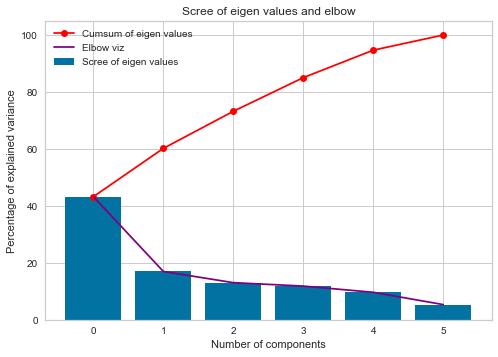

In [216]:
#ratio_var= pca.explained_variance_ratio_*100 # Pourcentage de variance cumul√© expliqu√© par les n premi√®res composantes.
plt.bar(np.arange(len(model_pca.eig_[1])), model_pca.eig_[1], label="Scree of eigen values")
plt.plot(np.arange(len(model_pca.eig_[1])), model_pca.eig_[2],c="red",marker='o', label="Cumsum of eigen values")
plt.plot(np.arange(len(model_pca.eig_[1])), model_pca.eig_[1],c="purple",marker='_', label="Elbow viz")

plt.xlabel("Number of components")
plt.ylabel("Percentage of explained variance",)
plt.title("Scree of eigen values and elbow")
plt.xticks(range(len(model_pca.eig_[1])))
plt.legend()
plt.show()

**Observation**<br>
L'√©bouli des valeurs propores indique 2 composantes √©galement.
____________


In [217]:
eigen_vector=pd.DataFrame(model_pca.eigen_vectors_)
eigen_vector

0         1         2         3         4         5
0  0.085067 -0.940963 -0.287963  0.102109 -0.118016 -0.008687
1 -0.330859 -0.308102  0.884964  0.047723  0.100560 -0.007311
2 -0.394021 -0.108755 -0.165719 -0.865014  0.239175 -0.001674
3 -0.506923  0.074047 -0.108915  0.086320 -0.569115 -0.627965
4 -0.439277  0.003928 -0.269012  0.447457  0.708769 -0.179112
5  0.527359 -0.048324  0.149073 -0.177136  0.304154 -0.757263

**Observation**<br>
Ce tableau de composantes n'est pas ordonn√© comme il faut contrairement √† eigen_vectors de la librairie scikit-learn. Les lignes et les colonnes sont invers√©ses.<br>
(voir projet 9) 

Je transpose le r√©sultat.
_____________________

In [218]:
eigen_vector=eigen_vector.transpose()
eigen_vector

0         1         2         3         4         5
0  0.085067 -0.330859 -0.394021 -0.506923 -0.439277  0.527359
1 -0.940963 -0.308102 -0.108755  0.074047  0.003928 -0.048324
2 -0.287963  0.884964 -0.165719 -0.108915 -0.269012  0.149073
3  0.102109  0.047723 -0.865014  0.086320  0.447457 -0.177136
4 -0.118016  0.100560  0.239175 -0.569115  0.708769  0.304154
5 -0.008687 -0.007311 -0.001674 -0.627965 -0.179112 -0.757263

Je v√©rifie que les variables sont bien d√©corr√©l√©es (m√™me si je n'avais pas v√©rifi√© avant)

In [222]:
X_projected=model_pca.transform(X)

comp1=X_projected.iloc[:,0]
comp2=X_projected.iloc[:,1]
coef_corr_comp, p_value_comp = stats.pearsonr(comp1, comp2)
coef_corr_comp1, p_value_comp1 = stats.spearmanr(comp1, comp2)
print("Coefficients Pearson :",coef_corr_comp, p_value_comp)
print("Coefficients Spearman :",coef_corr_comp1, p_value_comp1)


Coefficients Pearson : 2.96637714392034e-16 0.9999999999997436
Coefficients Spearman : 0.024716988763106122 0.3387525475303045


**Observation**<br>
Il n'y a pas de corr√©lation lin√©aires entre les 2 composantes, le coefficient de corr√©lation est proche de 0 et une p-value √©tant bien sup√©rieur au seuil de rejet de 0.05 dans les 2 tests (param√©trique et non param√©trique√†, ce qui signifie qu'on acc√®pte l'hypoth√®se nulle (les variables sont ind√©pendantes).<br>
L'ACP transforme un jeu de variables en un nouvel ensemble de variables non corr√©l√©es.
_____________________

Affichage de :
- cercle de corr√©lation regroupant les 2 1res composantes
- tableaux de contribution des 2 variables du 1er plan factoriel. 

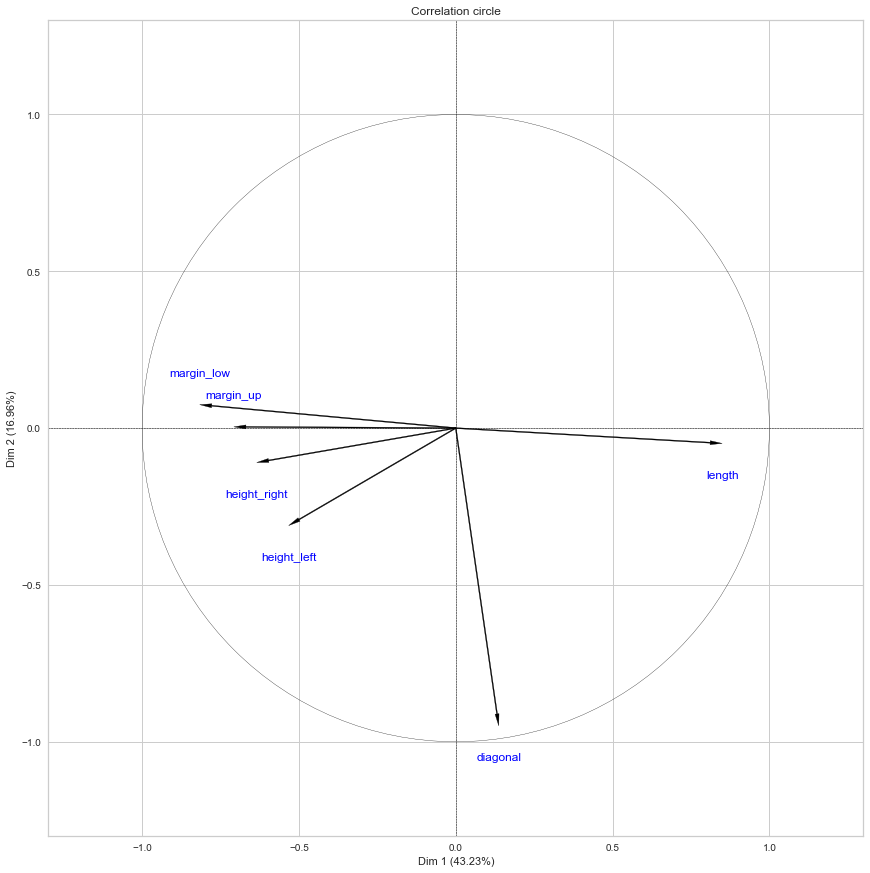

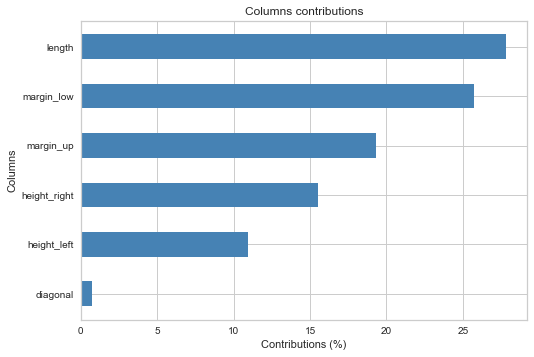

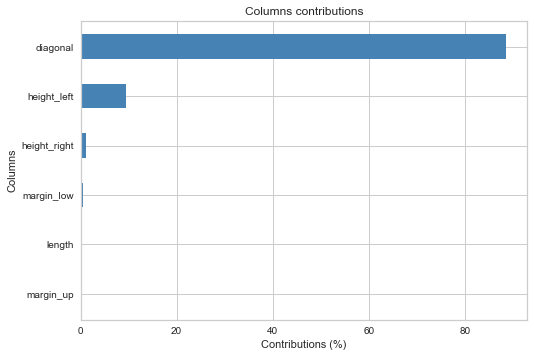

In [223]:
model_pca.correlation_circle(num_x_axis=1, num_y_axis=2,figsize=(15,15))
model_pca.plot_col_contrib(1,n_components)
model_pca.plot_col_contrib(2,n_components)

**Observation**<br>

Les axes factoriels sont des axes virtuels issus d‚Äôune synth√®se entre les variables de l‚Äôanalyse. Ils n‚Äôont pas n√©cessairement un sens pr√©cis m√™me si on peut souvent leur trouver un sens en s‚Äôaidant notamment de la repr√©sentation des variable sur le cercle de corr√©lation.<br>
- Les points les plus int√©ressants sont ceux qui sont assez proches d‚Äôun des axes, et assez loin de l‚Äôorigine : *lenght, margin_low, margin_up* et *diagonal* qui sont tr√®s bien repr√©sent√©s sur le mapping.
- *Diagonal* et *lenght* sont les variables les mieux repr√©sent√©s sur le mapping car la plus proche du cercle de corr√©lation, elles contribuent chacune le plus √† leur axe, positivement pour *lenght* sur l'axe 1 et n√©gativement pour *diagonal* sur l'axe 2.<br>
- La variable *height_left* est celle qui a le moins d'influence.
- L‚Äôangle plut√¥t ferm√© (en partant de l‚Äôorigine) que forment les points *margin_up* et *margin_low* indique une corr√©lation entre ces 2 variables.<br>
- Ces derni√®res contribuent √©galement tr√®s fortement et n√©gativement √† l'axe 1.<br>
- En revanche, l‚Äôangle quasi droit form√© par *lenght* et *diagonal* indique que ces deux variables sont ind√©pendantes entre elles.
- La longueur du billet est anticorr√©l√©e aux autres dimensions du billet, hauteur et marges.

**L'axe 2 renseignerait sur la diagonale du billet et l'axe 1 sur les autres mesures.**

_______________________

### Clustering (K-means) sur ACP
On fait le clustering sur les variables initiales et pas synth√©tiques. Il ne faut pas centrer et r√©duire pour ne pas √©liminer l'importance entre les axes, on ne veut pas donner autant d'importance √† chaque dimension.<br>

In [224]:
X_projected=model_pca.transform(X.to_numpy())
X_projected=pd.DataFrame(X_projected,columns=["F"+str(i+1) for i in range (n_components)], index=X.index)
print("Coordonn√©es des coefficients de corr√©lation des individus")
X_projected#.iloc[:,:2]

Coordonn√©es des coefficients de corr√©lation des individus


F1        F2        F3        F4        F5        F6
0    -1.646419 -0.749647  2.394294 -3.184402  0.314579  0.014526
1     2.019672  2.207642 -1.000617 -0.070609  0.042315  0.479301
2     0.971044 -2.619099  1.196717  0.916513 -0.847277 -0.204551
3     1.376320  1.816679  0.650449 -0.826755  0.808583  0.230168
4    -0.148697  0.563972  0.858627  1.791052  1.173776  0.291613
...        ...       ...       ...       ...       ...       ...
1495 -1.427638  0.268026  0.948560 -0.520487 -0.238880  1.318027
1496 -3.279923 -1.319117  0.616394 -0.335953 -0.112300  0.540884
1497 -1.889331  0.601237 -0.546015  0.098179 -0.300976 -0.502765
1498 -1.789360 -0.511604  0.028650  0.475333  0.349059 -0.530227
1499 -1.042595  1.469825  0.486350  0.686960  0.485492  0.231229

[1500 rows x 6 columns]

Afin de pouvoir comparer la r√©gression logisique avec les kmeans, je vais cr√©er 2 clusters. <br>
Mais dans l'absolu, le k-means a pour objectif de s√©parer les donn√©es en groupes homog√®nes ayant des caract√©ristiques communes. Et pourraient r√©v√©ler, par exemple, un groupe de vrai billets, un groupe de faux billets, et un groupe proches des vrais billets mais qui sont faux.<br>
Je regarde tout de m√™me ce que les m√©thodes du coude et du score de silhouette pr√©conisent comme nombre de cluster.

#### Recherche du nombre de clusters : M√©thode du coude

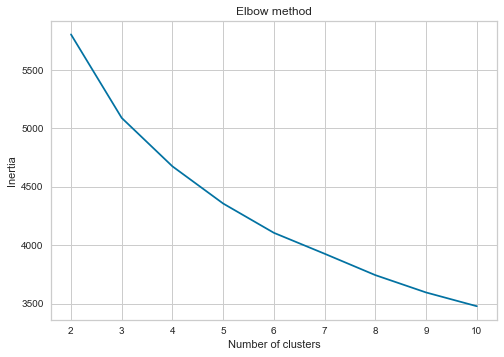

In [225]:
inertias =[]
for i in range(2, 11):
    model_kmeans = KMeans(n_clusters = i, random_state=42).fit(X_projected)#.iloc[:,:2])
    #kmeans.fit(X_projected)
    inertias.append(model_kmeans.inertia_)

plt.plot(range(2, 11), inertias)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Recherche du nombre de clusters : M√©thode de l'analyse du coefficient de silhouette

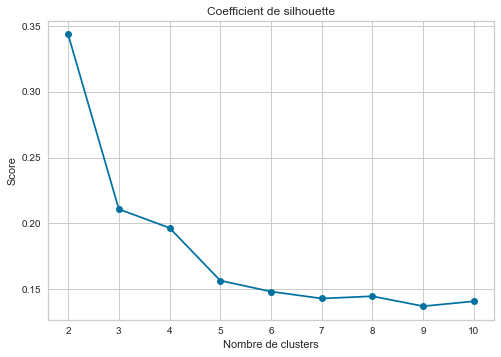

In [226]:
#Use silhouette score
silhouettes=[]
for n_clusters in range(2,11):
    model_kmeans2 = KMeans(n_clusters=n_clusters,n_init=10, init='k-means++',random_state=0) # Instantiate the Kmeans model with 10 times a random init
    model_kmeans2.fit(X_projected) # Fit the KMeans model on normalized data
    score = silhouette_score(X_projected, model_kmeans2.labels_, metric='euclidean') #Calculate Silhoutte coefficient Score 
    silhouettes.append(score)
    
    #print(f"Quand le nombre de clusters vaut {n_clusters}, le score de silhouette vaut {score:.3f}.")  

plt.plot(range(2,11),silhouettes, marker='o') 
plt.title("Coefficient de silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score")
plt.show()

**Observation**<br>
Les coefficients sont proches de 0 et indiquent un nombre de 2 clusters.<br>
Rappel : le coefficient peut varier entre -1 et +1. Un coefficient proche de +1 signifie que l‚Äôobservation est situ√©e bien √† l‚Äôint√©rieur de son propre cluster, tandis qu‚Äôun coefficient proche de 0 signifie qu‚Äôelle se situe pr√®s d‚Äôune fronti√®re ; enfin, un coefficient proche de -1 signifie que l‚Äôobservation est associ√©e au mauvais cluster. 

Pour la m√©thode du coude, il n'y a pas de donn√©es franches, on pourrait partir sur 2 ou 3.<br>
______________

### Pr√©diction

Je construis mon mod√®le sur 2 clusters et je lance la pr√©diction

In [227]:
model_kmeans = KMeans(n_clusters = 2, random_state=42)
model_kmeans.fit(X_projected)

# Stockage de l'information contenant le cluster :
y_pred = model_kmeans.predict(X_projected)
# ou
clusters_km = model_kmeans.labels_
clusters_km

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [228]:
y_pred

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [229]:
X_projected.loc[:,["F1","F2"]]

F1        F2
0    -1.646419 -0.749647
1     2.019672  2.207642
2     0.971044 -2.619099
3     1.376320  1.816679
4    -0.148697  0.563972
...        ...       ...
1495 -1.427638  0.268026
1496 -3.279923 -1.319117
1497 -1.889331  0.601237
1498 -1.789360 -0.511604
1499 -1.042595  1.469825

[1500 rows x 2 columns]

In [230]:
final_df=pd.concat([banknotes,X_projected.loc[:,["F1","F2"]],pd.DataFrame(clusters_km, index=X_projected.index, columns=["cluster"])], axis=1)
final_df

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           True    171.81       104.86        104.95        4.52       2.89   
1           True    171.46       103.36        103.66        3.77       2.99   
2           True    172.69       104.48        103.50        4.40       2.94   
3           True    171.36       103.91        103.94        3.62       3.01   
4           True    171.73       104.28        103.46        4.04       3.48   
...          ...       ...          ...           ...         ...        ...   
1495       False    171.75       104.38        104.17        4.42       3.09   
1496       False    172.19       104.63        104.44        5.27       3.37   
1497       False    171.80       104.01        104.12        5.51       3.36   
1498       False    172.06       104.28        104.06        5.17       3.46   
1499       False    171.47       104.15        103.82        4.63       3.37   

      length        F1        F2  cluster  
0     112.83 -1.646419 -0.749647        0  
1     113.09  2.019672  2.207642        1  
2     113.16  0.971044 -2.619099        1  
3     113.51  1.376320  1.816679        1  
4     112.54 -0.148697  0.563972        1  
...      ...       ...       ...      ...  
1495  111.28 -1.427638  0.268026        0  
1496  110.97 -3.279923 -1.319117        0  
1497  111.95 -1.889331  0.601237        0  
1498  112.25 -1.789360 -0.511604        0  
1499  112.07 -1.042595  1.469825        0  

[1500 rows x 10 columns]

A SUPPRIMER <u>**Observation**</u><br>
On voit que le cluster 0 correspond √† True, et 1 √† False.
Pour faciliter la compr√©hension, j'affecte 0 √† False et 1 √† True et je passe is_genuine

In [231]:
#final_df['cluster'] = np.where(final_df.cluster == 0, 1 , 0)

In [232]:
clusters_cendroids = model_kmeans.cluster_centers_
clusters_cendroids

array([[-2.06737521,  0.07383048, -0.0907349 ,  0.08644584, -0.13954152,
         0.04718903],
       [ 1.02133277, -0.03647402,  0.04482521, -0.04270631,  0.06893685,
        -0.02331251]])

Projection des individus et des centro√Ødes avec visualisation kmeans sur ACP

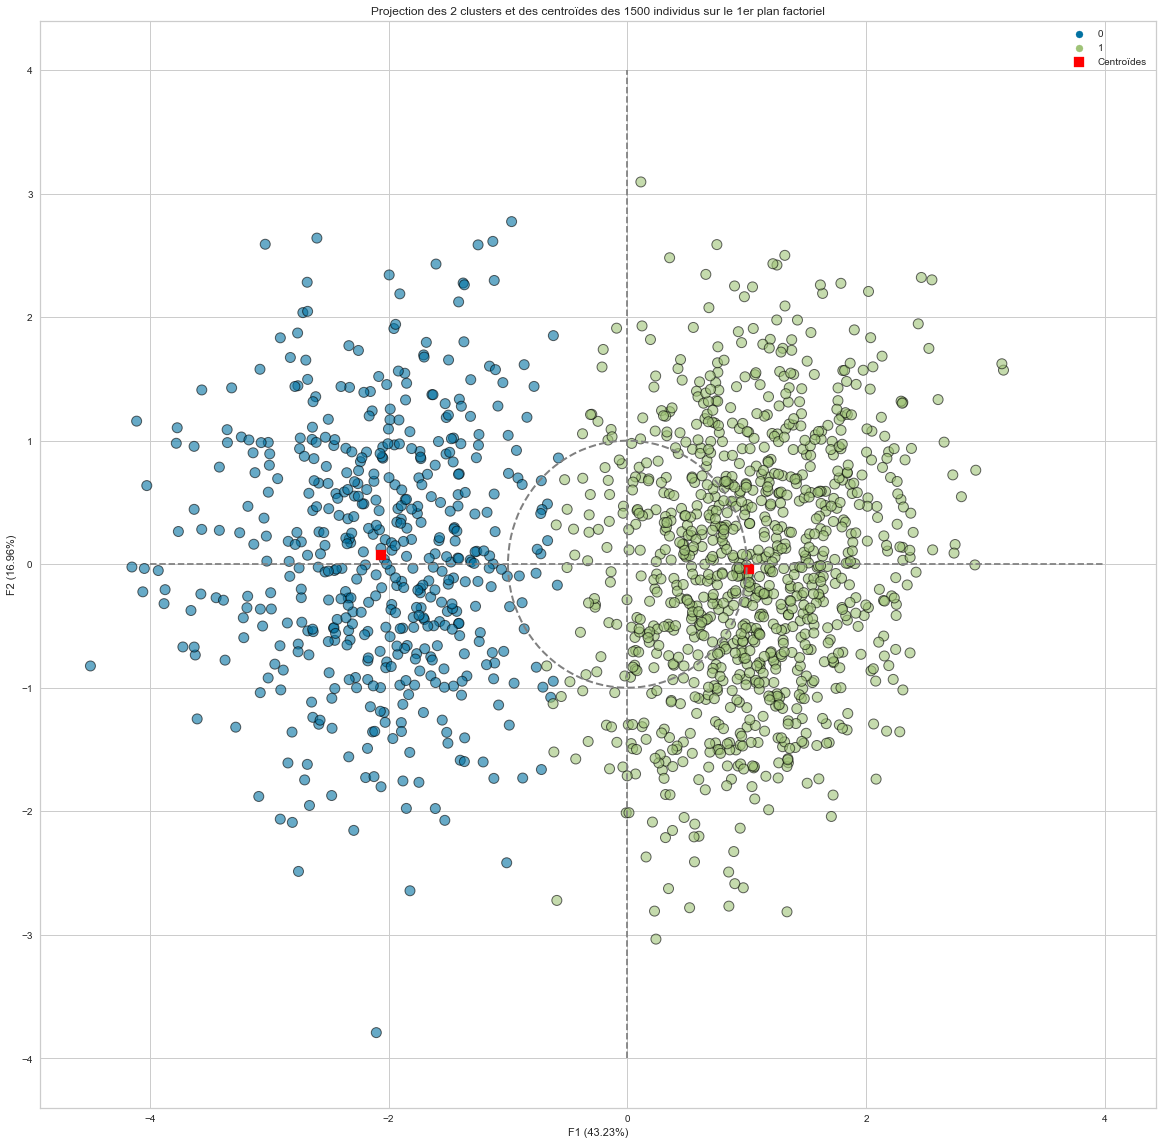

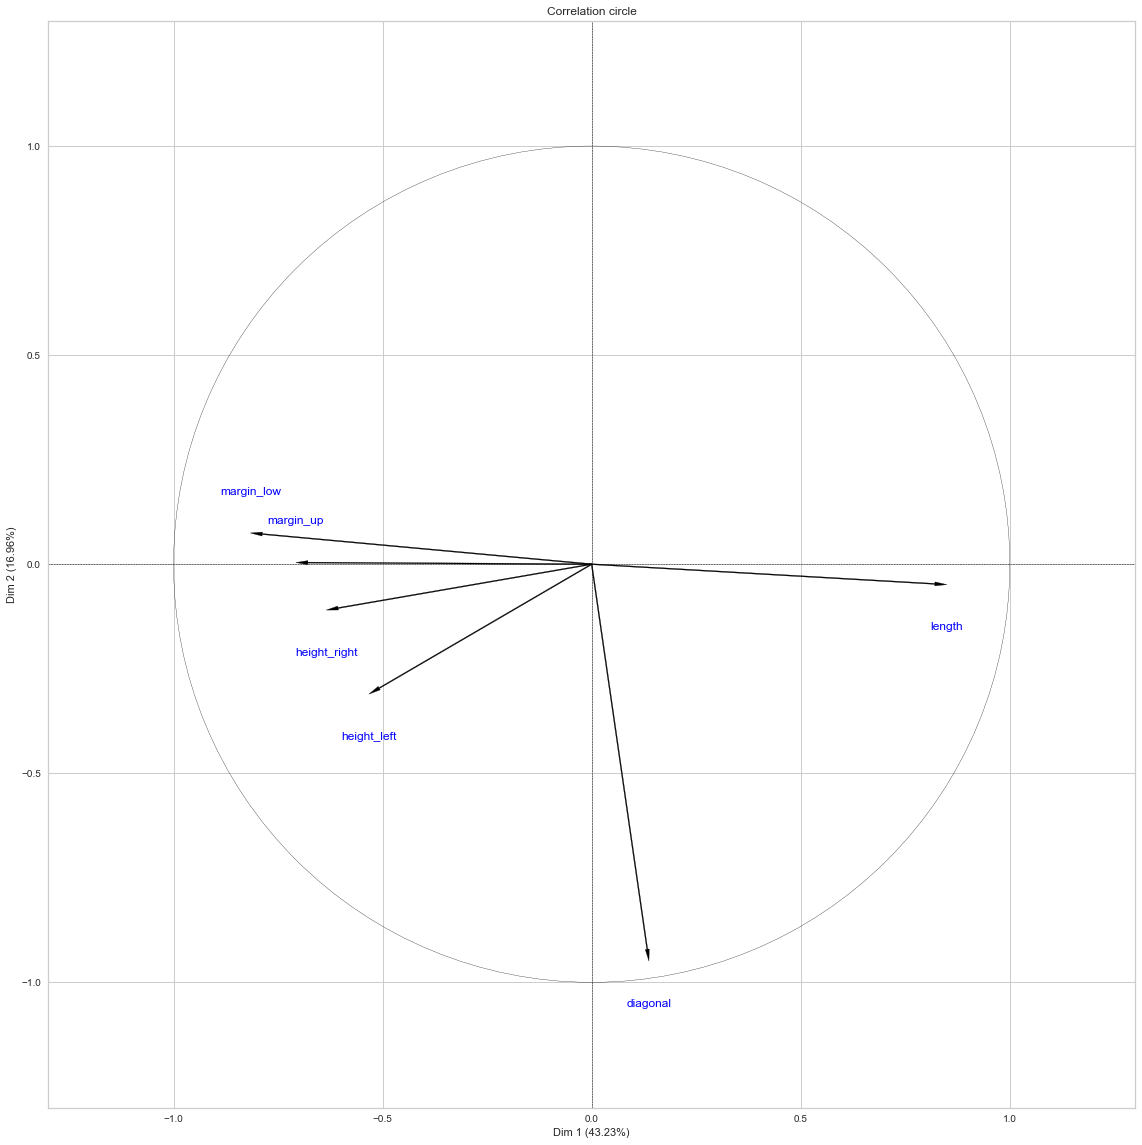

In [233]:
plt.figure(figsize=(20, 20))

kwargs  =   {'edgecolor':"black", # for edge color
             'linewidth':1, # line width of spot
             'linestyle':'-', # line style of spot
            }

sns.scatterplot(x=X_projected.iloc[:,0],y=X_projected.iloc[:,1], hue=final_df.cluster, alpha=0.6, **kwargs, s=100)
plt.scatter(clusters_cendroids[:,0], clusters_cendroids[:,1], marker='s', s=100, c='red', label="Centro√Ødes")

plt.legend()
draw_circle()
# affichage des lignes horizontales et verticales
plt.plot([-4, 4], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-4, 4], color='grey', ls='--')

plt.xlabel(f'F1 ({model_pca.eig_[1][0]:.2f}%)')
plt.ylabel(f'F2 ({model_pca.eig_[1][1]:.2f}%)')
plt.title(f"Projection des 2 clusters et des centro√Ødes des {X_projected.shape[0]} individus sur le 1er plan factoriel")

plt.show()

model_pca.correlation_circle(num_x_axis=1, num_y_axis=2,figsize=(20,20))

# Autre m√©thode avec matplotlib

#colors = ['red', 'blue','green']
#color_centroids=["black"]

#for k in [0,1]:
#    plt.scatter(final_df.F1[final_df.cluster==k],final_df.F2[final_df.cluster==k],c=colors[k],
#                edgecolors="black", linewidths=1.4, s=40, alpha=0.5,label=f"Cluster {k}")

#    plt.legend()
#    plt.scatter(clusters_cendroids[:,0], clusters_cendroids[:,1],edgecolors="black",s=100, marker="s",alpha=1,c="black", label="Centro√Øds")

#draw_circle()
# affichage des lignes horizontales et verticales
#plt.plot([-4, 4], [0, 0], color='grey', ls='--')
#plt.plot([0, 0], [-4, 4], color='grey', ls='--')

#plt.xlabel(f'F1 ({model_pca.eig_[1][0]:.2f}%)')
#plt.ylabel(f'F2 ({model_pca.eig_[1][1]:.2f}%)')
#plt.title(f"Projection des 2 clusters et des centro√Ødes des {X_projected.shape[0]} individus sur le 1er plan factoriel")
#plt.show()

<u>**Observation**</u><br>
La projection et le cercle de corr√©lation (regroupant les 2 1res composantes) nous indique que les vrais billets sont plus longs, et que les faux ont une tendance √† avoir une hauteur et une marge plus petites.<br>
Les centro√Ødes sont bien repr√©sentatifs.

### Evaluation du mod√®le k-means

On utilise la matrice de confusion avec :
- La colonne *is_genuine* qui retourne la vraie valeur,
- La colonne cluster qui affiche la pr√©diction (le cluster)

In [234]:
final_df.is_genuine.value_counts()

True     1000
False     500
Name: is_genuine, dtype: int64

In [235]:
matrix = pd.crosstab(final_df.is_genuine*1,final_df.cluster,colnames=['Pr√©dictions'], rownames=['Observations'], margins=True)
matrix.columns = ['Pr√©diction_Faux_billets','Pr√©diction_Vrais_billets',"Total"]
matrix.index = ['Faux_billets','Vrais_billets',"Total"]
matrix

Pr√©diction_Faux_billets  Pr√©diction_Vrais_billets  Total
Faux_billets                       486                        14    500
Vrais_billets                       10                       990   1000
Total                              496                      1004   1500

Je cr√©e mon dataframe sans margins pour repr√©senter la r√©partition sous forme de heatmap.

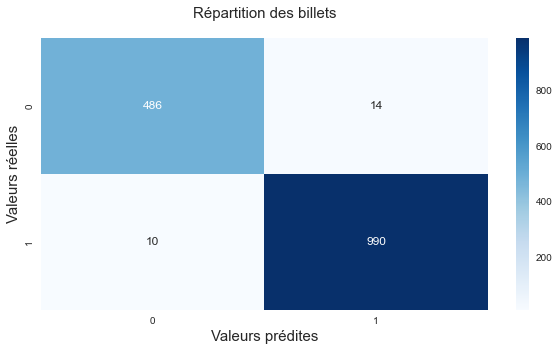

In [236]:
matrix = pd.crosstab(final_df.is_genuine*1,final_df.cluster)
plot_crosstab(matrix, "R√©partition des billets")

Je calcule la performance de mon mod√®le avec :
 - Rappel (recall) = TP / (TP + FN)
 - Pr√©cision (precision) = TP / (TP + FP)
 - Sp√©cificit√© (specificity) = TN / (FP + TN)
 - F‚àímesure = 2√ó(Pr√©cision√óRappel)/(Pr√©cision+Rappel)=2TP / (2TP + FP + FN)
 

Je cr√©√© mes tableaux de valeurs observ√©es et valeurs pr√©dites

In [237]:
TN = matrix[0][0]
FP = matrix[1][0]
FN = matrix[0][1]
TP = matrix[1][1]
#Ou comme √ßa
#y_true = np.array(final_df.is_genuine*1)
#y_pred = np.array(final_df.cluster)
#TN, FP, FN, TP = metrics.confusion_matrix(y_true, y_pred).ravel()

Je lance les mesures

In [238]:
recall = TP / (TP + FN) 
precision = TP / (TP + FP) 
specificity = TN / (FP + TN) 
f_mesure = 2*TP / (2*TP + FP + FN) 
accuracy = (TP + TN) / (TP + TN + FP + FN) 

print(f'''Le nombre de vrais positifs vaut : {TP}
Le nombre de vrais n√©gatifs vaut : {TN}
Le nombre de faux positifs vaut : {FP}
Le nombre de faux n√©gatifs vaut : {FN}

On peut maintenant calculer les mesures de performances : 
recall = {recall:.2%}
precision = {precision:.2%}
accuracy = {accuracy:.2%}
specificity = {specificity:.2%}
f_mesure = {f_mesure:.2%}

''')

Le nombre de vrais positifs vaut : 990
Le nombre de vrais n√©gatifs vaut : 486
Le nombre de faux positifs vaut : 14
Le nombre de faux n√©gatifs vaut : 10

On peut maintenant calculer les mesures de performances : 
recall = 99.00%
precision = 98.61%
accuracy = 98.40%
specificity = 97.20%
f_mesure = 98.80%




In [239]:
kmeans_model_evaluation = pd.DataFrame(data=[precision,recall,accuracy,specificity,f_mesure], index=["precision","recall","accuracy","specificity","f_mesure"], columns=["measures_kmeans"])
kmeans_model_evaluation=round(kmeans_model_evaluation*100,2)
kmeans_model_evaluation

measures_kmeans
precision              98.61
recall                 99.00
accuracy               98.40
specificity            97.20
f_mesure               98.80

## Choix du mod√®le de pr√©diction

Je concat√®ne mes 2 dataframes de mesures pour comparer les r√©sultats.

In [240]:
comparison_model_evaluation = pd.concat([log_reg_model_evaluation, kmeans_model_evaluation],axis=1)
comparison_model_evaluation

measures_log_reg  measures_kmeans
precision               99.00            98.61
recall                  99.33            99.00
accuracy                98.89            98.40
specificity             98.00            97.20
f_mesure                99.17            98.80

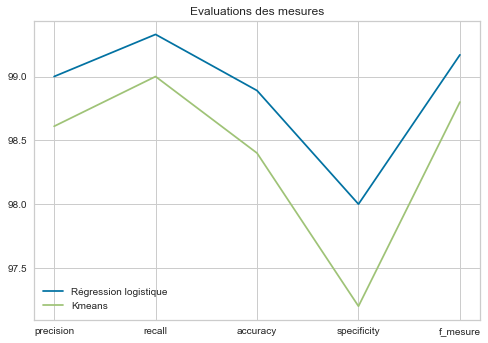

In [241]:
plt.plot(comparison_model_evaluation.loc[:,"measures_log_reg"], label="R√©gression logistique")
plt.plot(comparison_model_evaluation.loc[:,"measures_kmeans"], label='Kmeans')
plt.title("Evaluations des mesures")
plt.legend()

plt.show()

In [242]:
comparison_model_evaluation["best_measure"]=""
comparison_model_evaluation["difference"]=""
for i in range (comparison_model_evaluation.shape[0]):
    col1 = comparison_model_evaluation.iloc[i,0]
    col2 = comparison_model_evaluation.iloc[i,1]
    if col1 >= col2:
        comparison_model_evaluation.iloc[i,2]="log_reg"
        comparison_model_evaluation.iloc[i,3]=col1-col2
    else:
        comparison_model_evaluation.iloc[i,2]="kmeans"
        comparison_model_evaluation.iloc[i,3]=col2-col1

In [243]:
comparison_model_evaluation

measures_log_reg  measures_kmeans best_measure difference
precision               99.00            98.61      log_reg       0.39
recall                  99.33            99.00      log_reg       0.33
accuracy                98.89            98.40      log_reg       0.49
specificity             98.00            97.20      log_reg        0.8
f_mesure                99.17            98.80      log_reg       0.37

**Les 2 mod√®les donnent de tr√®s bons r√©sultats. Mais le Kmeans n'est pas une m√©thode de pr√©diction m√™me si notre √©chantillon est sensible au clustering.<br>
On se dirigera donc plut√¥t vers la r√©gression logistique qui est un mod√®le pr√©dictif qui va apprendre au fur et √† mesure de l'injection de nouvelles donn√©es.**

# V. IDENTIFICATION VRAIS/FAUX BILLETS

## Jeu de donn√©es

In [245]:
input_file = input('Saisir le nom du fichier ici : ')

Saisir le nom du fichier ici :  billets_production.csv


In [246]:
prod_banknotes = pd.read_csv("Fichiers/"+input_file, sep=",")
prod_banknotes

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

Je retire la colonne ID que je stocke avec l'index de ligne pour le r√©injecter √† la fin

In [247]:
prod_banknotes.iloc[:,:-1]


diagonal  height_left  height_right  margin_low  margin_up  length
0    171.76       104.01        103.54        5.21       3.30  111.42
1    171.87       104.17        104.13        6.00       3.31  112.09
2    172.00       104.58        104.29        4.99       3.39  111.57
3    172.49       104.55        104.34        4.44       3.03  113.20
4    171.65       103.63        103.56        3.77       3.16  113.33

## Pr√©diction

In [248]:
y_pred=model_reg_log.predict(prod_banknotes.iloc[:,:-1])
y_pred

array([0, 0, 0, 1, 1])

## Probabilit√©s

In [249]:
y_proba=pd.DataFrame(model_reg_log.predict_proba(prod_banknotes.iloc[:,:-1]), columns=["prob_false (%)","prob_true (%)"])
y_proba=round(y_proba*100,2)
y_proba

prob_false (%)  prob_true (%)
0           99.48           0.52
1           99.89           0.11
2           99.87           0.13
3            9.12          90.88
4            0.04          99.96

<u>**Observation**</u><br>
Le seuil de probabilit√© est tr√®s haut, sup√©rieur √† 90%, il y a de fortes chances que nos pr√©dictions soient bonnes.

## Consolidation r√©sultat final

On ajoute les r√©sultats (pr√©diction et pourcentage) au fichier en entr√©e.

In [250]:
prod_banknotes=pd.concat([prod_banknotes,y_proba], axis=1)
prod_banknotes["is_genuine"]=np.where(y_pred==0,"False","True")
prod_banknotes

diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

   prob_false (%)  prob_true (%) is_genuine  
0           99.48           0.52      False  
1           99.89           0.11      False  
2           99.87           0.13      False  
3            9.12          90.88       True  
4            0.04          99.96       True

J'exporte le fichier r√©sultat.

In [251]:
prod_banknotes.to_csv("Fichiers/prod_banknotes_pred.csv")